# 1. **Libraries Import**

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import plotly.express as px
import plotly.io as pio



#Pre-Processing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


#models
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Kernels
from sklearn.gaussian_process.kernels import RBF, WhiteKernel,Matern,ExpSineSquared,RationalQuadratic, ConstantKernel as C

#Scipy
from scipy.spatial import distance
import scipy
import scipy.optimize as opt
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping
from scipy.optimize import minimize
from scipy.stats import norm

#Pytorch
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch import optim

#Optuna
import optuna


# 2. **Dataset**

## 2.1 Loading the dataset

In [62]:
## Loading all the datasets

# Feature Table
#feature_table = pd.read_csv("D:\Research\Biomarkers_Ultimate\Data\\298_samples_orginal\\feature-table.tsv", sep=',')

# Labels
#label_data = pd.read_excel("D:\Research\Biomarkers_Ultimate\Data\\298_samples_orginal\label_data.xlsx")

# Lefse_data
#lefse_data=pd.read_csv("D:\Research\Biomarkers_Ultimate\Data\\298_samples_orginal\lefse_data_0.01pvalue.csv")
#Lda_threshold = 0

# If not meta data add meta_data = None
#meta_data = pd.read_excel("D:\Research\Biomarkers_Ultimate\Data\\298_samples_orginal\meta_data.xlsx")
# meta_data = None

#Lda_trans = False
#top_10_feature_true = True
#SFFS_true = False

In [63]:
# ## Loading all the datasets

# # Feature Table
feature_table = pd.read_csv("/home/dell/NSCLC_code/16_aug_24/Data/298_samples_orginal/feature-table.tsv", sep=',')

# # Labels
label_data = pd.read_excel("/home/dell/NSCLC_code/16_aug_24/Data/298_samples_orginal/label_data.xlsx")

# # Lefse_data
lefse_data=pd.read_csv("/home/dell/NSCLC_code/16_aug_24/Data/298_samples_orginal/lefse_data_with_species.csv")
Lda_threshold = 2.0

# # If not meta data add meta_data = None
meta_data = pd.read_excel("/home/dell/NSCLC_code/16_aug_24/Data/298_samples_orginal/meta_data.xlsx")
# # meta_data = None

Lda_trans = False
top_10_feature_true = True
SFFS_true = False

In [64]:
meta_data

,Sample_id,env_material,disease type,host_sex,smoker,Host_Age
0,SRR3991333,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for less than 6 months,63.91513
1,SRR3991334,lung non-malignant tissue,lung adenocarcinoma,female,smoker quit for less than 6 months,62.71321
2,SRR3991335,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for at least 6 months,74.17385
3,SRR3991336,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for less than 6 months,64.72827
4,SRR3991337,lung non-malignant tissue,squamous cell carcinoma,male,smoker quit for less than 6 months,58.65572
...,...,...,...,...,...,...
293,SRR3991626,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for less than 6 months,56.35866
294,SRR3991627,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for at least 6 months,76.47091
295,SRR3991628,lung non-malignant tissue,lung adenocarcinoma,male,smoker quit for less than 6 months,51.89049
296,SRR3991629,lung non-malignant tissue,squamous cell carcinoma,male,smoker quit for less than 6 months,73.14716


In [65]:
# OTU_ID, PatientID1, PatientID2 ..., Taxonomy

feature_table_copy = copy.deepcopy(feature_table)

######### LABEL DATA #########
# PatientID: Treatment
label_data_np=np.array(label_data)

for i in range(len(label_data_np)):
    if (label_data_np[i][1] =='Squamous cell carcinoma'):
        label_data_np[i][1] = 'Squamous'

map_id_to_label = {}
for i in range(len(label_data_np)):
    map_id_to_label[label_data_np[i][0]] = label_data_np[i][1]

print(f'Unique labels: {np.unique(label_data_np[:,1])}')

map_otu_to_taxo = {}
for i,otu in enumerate(list(feature_table["otu_id"])):
    map_otu_to_taxo[f'OTU_{i}'] = feature_table.loc[i, 'taxonomy']

######### Cleaning the Data #########
feature_table_copy = feature_table_copy.drop(columns=["otu_id","taxonomy"])
feature_table_copy = feature_table_copy.T
feature_table_copy.columns = list(map_otu_to_taxo.keys())

# Creating the Treatment Column
feature_table_copy["label"] = [map_id_to_label[i] for i in feature_table_copy.index]
feature_table_copy

# Removing the rows with NaN values
feature_table_copy = feature_table_copy.dropna()

# Removing the rows with "lung_normal_tissue" label
# feature_table_copy = feature_table_copy[feature_table_copy["label"] != "lung normal tissue"]
# feature_table_copy = feature_table_copy[feature_table_copy["label"] != "lung normal tissue "]
feature_table_copy = feature_table_copy[feature_table_copy["label"] != "adenoSquamous cell carcinoma"]

table_data = copy.deepcopy(feature_table_copy)

# Uncoding the labels
le = preprocessing.LabelEncoder()

table_data["label"] = le.fit_transform(table_data["label"])
print(f'Class Labels: {le.classes_}')

numpy_data = table_data.drop(columns=["label"]).to_numpy()
table_data

Unique labels: ['Adenocarcinoma' 'Squamous' 'adenoSquamous cell carcinoma']
Class Labels: ['Adenocarcinoma' 'Squamous']


,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_3410,OTU_3411,OTU_3412,OTU_3413,OTU_3414,OTU_3415,OTU_3416,OTU_3417,OTU_3418,label
SRR3991455,70,64,61,59,56,52,46,44,40,40,...,0,0,0,0,0,0,0,0,0,1
SRR3991405,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991550,0,0,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991513,0,0,0,0,0,0,0,0,1,7,...,10,10,0,0,0,0,0,0,0,0


In [66]:
# Count the number of samples for each label before encoding
label_counts = feature_table_copy["label"].value_counts()

# Print the counts for each label
print(label_counts)


label
Adenocarcinoma    136
Squamous          132
Name: count, dtype: int64


## 2.2 Taxonomy wise Data Division

In [67]:
taxonomy_arr = []

for i in range(len(map_otu_to_taxo)):
    taxonomy_arr.append(map_otu_to_taxo[f'OTU_{i}'])

print(f'Number of unique taxonomy: {len(np.unique(taxonomy_arr))}')
print(f'Lenght of the taxonomy array: {len(taxonomy_arr)}')

Number of unique taxonomy: 404
Lenght of the taxonomy array: 3419


### 2.3.1 Phyllum 

In [68]:
phyllum_labels=[]
count_no_phyllum=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>1):
    if (temp[1] not in phyllum_labels):
      phyllum_labels.append(temp[1])

# Counting the number of taxa with only dynasty labels
for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==1):
    count_no_phyllum=count_no_phyllum+1

print("Number of Taxa without the phyllum labels:-",count_no_phyllum)

print("No. of distinct phyllum are:-",len(phyllum_labels))
print(phyllum_labels)

# Processing the data to get the phyllum data
temp_dict={}
for i in range(len(phyllum_labels)):
  temp_dict[phyllum_labels[i]]=0

temps_arr=[]


for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>1):
      new_dict[temp[1]]=new_dict[temp[1]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

phylum_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

phylum_data.to_csv("phylum_data.csv")
phylum_data

Number of Taxa without the phyllum labels:- 0
No. of distinct phyllum are:- 18
[' p__Proteobacteria', ' p__Actinobacteriota', ' p__Firmicutes', ' p__Bacteroidota', ' p__Cyanobacteria', ' p__Deinococcota', ' p__Bdellovibrionota', ' p__Fusobacteriota', ' p__Patescibacteria', ' p__Campilobacterota', ' p__Verrucomicrobiota', ' p__Acidobacteriota', ' p__Chloroflexi', ' p__Dependentiae', ' p__Myxococcota', ' p__MBNT15', ' p__Desulfobacterota', ' p__WS2']


,p__Proteobacteria,p__Actinobacteriota,p__Firmicutes,p__Bacteroidota,p__Cyanobacteria,p__Deinococcota,p__Bdellovibrionota,p__Fusobacteriota,p__Patescibacteria,p__Campilobacterota,p__Verrucomicrobiota,p__Acidobacteriota,p__Chloroflexi,p__Dependentiae,p__Myxococcota,p__MBNT15,p__Desulfobacterota,p__WS2
SRR3991455,1730,130,266,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991405,749,43,49,172,25,0,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991368,1258,2229,502,254,0,103,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991360,911,11,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991582,229,0,29,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,185,0,55,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991550,6578,9,21,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0
SRR3991353,303,0,69,15,0,0,7,0,0,0,0,0,0,0,0,0,0,0
SRR3991513,613,11,47,118,0,0,0,0,123,0,0,0,0,0,0,0,0,0


### 2.3.2 Class

In [69]:
class_labels=[]
count_no_class=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>2):
    if (temp[2] not in class_labels):
      class_labels.append(temp[2])

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==2):
    count_no_class=count_no_class+1

print("Number of Taxa without the class labels:-",count_no_class)

print("No. of distinct class are:-",len(class_labels))
print(class_labels)


# Processing the data to get the class data
temp_dict={}
for i in range(len(class_labels)):
  temp_dict[class_labels[i]]=0

temp_dict

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>2):
      new_dict[temp[2]]=new_dict[temp[2]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

class_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

class_data.to_csv("class_data.csv")
class_data

Number of Taxa without the class labels:- 1
No. of distinct class are:- 34
[' c__Gammaproteobacteria', ' c__Alphaproteobacteria', ' c__Actinobacteria', ' c__Bacilli', ' c__Negativicutes', ' c__Bacteroidia', ' c__Vampirivibrionia', ' c__Deinococci', ' c__Rubrobacteria', ' c__Clostridia', ' c__Coriobacteriia', ' c__Oligoflexia', ' c__Fusobacteriia', ' c__Saccharimonadia', ' c__Parcubacteria', ' c__Campylobacteria', ' c__Gracilibacteria', ' c__Verrucomicrobiae', ' c__Blastocatellia', ' c__Bdellovibrionia', ' c__Chlamydiae', ' c__Anaerolineae', ' c__Babeliae', ' c__Acidimicrobiia', ' c__Acidobacteriae', ' c__ABY1', ' c__Omnitrophia', ' c__Myxococcia', ' c__MBNT15', ' c__Cyanobacteriia', ' c__Desulfovibrionia', ' c__Thermoleophilia', ' c__WS2', ' c__Lentisphaeria']


,c__Gammaproteobacteria,c__Alphaproteobacteria,c__Actinobacteria,c__Bacilli,c__Negativicutes,c__Bacteroidia,c__Vampirivibrionia,c__Deinococci,c__Rubrobacteria,c__Clostridia,...,c__Acidobacteriae,c__ABY1,c__Omnitrophia,c__Myxococcia,c__MBNT15,c__Cyanobacteriia,c__Desulfovibrionia,c__Thermoleophilia,c__WS2,c__Lentisphaeria
SRR3991455,1335,395,130,181,85,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991405,749,0,43,49,0,172,25,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,933,325,2213,499,0,254,0,103,16,3,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,833,78,5,75,0,0,0,0,6,8,...,0,0,0,0,0,0,0,0,0,0
SRR3991582,118,111,0,29,0,0,13,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,73,112,0,55,0,26,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991550,6376,202,9,21,0,137,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991353,291,12,0,69,0,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991513,522,91,11,37,0,118,0,0,0,10,...,0,0,0,0,0,0,0,0,0,0


### 2.3.3 Order

In [70]:
order_labels=[]
count_no_order=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>3):
    if (temp[3] not in order_labels):
      order_labels.append(temp[3])

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==3):
    count_no_order=count_no_order+1

print("Number of Taxa without the order labels:-",count_no_order)

print("No. of distinct order are:-",len(order_labels))
print(order_labels)

temp_dict={}
for i in range(len(order_labels)):
  temp_dict[order_labels[i]]=0

temp_dict

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>3):
      new_dict[temp[3]]=new_dict[temp[3]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

order_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

order_data.to_csv("order_data.csv")
order_data

Number of Taxa without the order labels:- 21
No. of distinct order are:- 86
[' o__Burkholderiales', ' o__Sphingomonadales', ' o__Pseudomonadales', ' o__Frankiales', ' o__Lactobacillales', ' o__Veillonellales-Selenomonadales', ' o__Xanthomonadales', ' o__Caulobacterales', ' o__Corynebacteriales', ' o__Flavobacteriales', ' o__Sphingobacteriales', ' o__Staphylococcales', ' o__Obscuribacterales', ' o__Micrococcales', ' o__Bacteroidales', ' o__Enterobacterales', ' o__Deinococcales', ' o__Cytophagales', ' o__Rhizobiales', ' o__Azospirillales', ' o__Acetobacterales', ' o__Rubrobacterales', ' o__Peptostreptococcales-Tissierellales', ' o__Pasteurellales', ' o__Bacillales', ' o__Bifidobacteriales', ' o__Rhodobacterales', ' o__Coriobacteriales', ' o__Lachnospirales', ' o__0319-6G20', ' o__Erysipelotrichales', ' o__Oscillospirales', ' o__Fusobacteriales', ' o__Thermales', ' o__Alteromonadales', ' o__Saccharimonadales', ' o__Candidatus_Nomurabacteria', ' o__Reyranellales', ' o__Exiguobacterales', '

,o__Burkholderiales,o__Sphingomonadales,o__Pseudomonadales,o__Frankiales,o__Lactobacillales,o__Veillonellales-Selenomonadales,o__Xanthomonadales,o__Caulobacterales,o__Corynebacteriales,o__Flavobacteriales,...,o__Candidatus_Magasanikbacteria,o__Chthoniobacterales,o__Absconditabacteriales_(SR1),o__CHAB-XI-27,o__Solirubrobacterales,o__Gastranaerophilales,o__WS2,o__Vibrionales,o__Candidatus_Peribacteria,o__Victivallales
SRR3991455,577,327,689,126,181,85,69,68,4,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991405,199,0,518,0,9,0,29,0,0,150,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,213,235,653,0,246,0,65,0,2210,169,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,155,2,678,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991582,85,66,33,0,29,0,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,50,72,18,0,55,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,0
SRR3991550,448,181,5731,0,21,0,185,17,0,137,...,0,0,0,0,0,0,0,0,0,0
SRR3991353,239,0,41,0,8,0,9,0,0,15,...,0,0,0,0,0,0,0,0,0,0
SRR3991513,333,60,165,0,34,0,24,0,0,91,...,0,0,11,0,0,0,0,0,0,0


### 2.3.4 Family

In [71]:
family_labels=[]
count_no_family=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>4):
    if (temp[4] not in family_labels):
      family_labels.append(temp[4])

for i in range(len(taxonomy_arr)):
    temp=taxonomy_arr[i]
    temp=temp.split(";")
    if (len(temp)==4):
        count_no_family=count_no_family+1

print("Number of Taxa without the family labels:-",count_no_family)

print("No. of distinct family are:-",len(family_labels))
print(family_labels)

temp_dict={}
for i in range(len(family_labels)):
  temp_dict[family_labels[i]]=0


temps_arr=[]
for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>4):
      new_dict[temp[4]]=new_dict[temp[4]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

family_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

family_data.to_csv("family_data.csv")
family_data


Number of Taxa without the family labels:- 16
No. of distinct family are:- 150
[' f__Comamonadaceae', ' f__Sphingomonadaceae', ' f__Pseudomonadaceae', ' f__Geodermatophilaceae', ' f__Moraxellaceae', ' f__Carnobacteriaceae', ' f__Veillonellaceae', ' f__Xanthomonadaceae', ' f__Caulobacteraceae', ' f__Oxalobacteraceae', ' f__Streptococcaceae', ' f__Burkholderiaceae', ' f__Corynebacteriaceae', ' f__Weeksellaceae', ' f__Sphingobacteriaceae', ' f__Staphylococcaceae', ' f__Obscuribacteraceae', ' f__Microbacteriaceae', ' f__Micrococcaceae', ' f__Bacteroidaceae', ' f__Aerococcaceae', ' f__Enterobacteriaceae', ' f__Rhodocyclaceae', ' f__Enterococcaceae', ' f__Deinococcaceae', ' f__uncultured', ' f__Beijerinckiaceae', ' f__Azospirillaceae', ' f__Flavobacteriaceae', ' f__Acetobacteraceae', ' f__Rhizobiaceae', ' f__Lactobacillaceae', ' f__Rubrobacteriaceae', ' f__Peptostreptococcales-Tissierellales', ' f__Alcaligenaceae', ' f__Pasteurellaceae', ' f__Intrasporangiaceae', ' f__Bacillaceae', ' f__Xant

,f__Comamonadaceae,f__Sphingomonadaceae,f__Pseudomonadaceae,f__Geodermatophilaceae,f__Moraxellaceae,f__Carnobacteriaceae,f__Veillonellaceae,f__Xanthomonadaceae,f__Caulobacteraceae,f__Oxalobacteraceae,...,f__Absconditabacteriales_(SR1),f__CHAB-XI-27,f__Solirubrobacteraceae,f__Gastranaerophilales,f__Parvularculaceae,f__WS2,f__Vibrionaceae,f__Candidatus_Peribacteria,f__Victivallaceae,f__Aquaspirillaceae
SRR3991455,443,327,431,126,258,117,85,69,68,105,...,0,0,0,0,0,0,0,0,0,0
SRR3991405,160,0,73,0,445,0,0,29,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,67,235,124,0,529,0,0,65,0,16,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,61,2,48,0,630,0,0,0,0,56,...,0,0,0,0,0,0,0,0,0,0
SRR3991582,4,66,33,0,0,29,0,0,13,39,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,43,72,7,0,11,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
SRR3991550,416,181,11,0,5720,0,0,185,17,19,...,0,0,0,0,0,0,0,0,0,0
SRR3991353,148,0,27,0,14,0,0,9,0,22,...,0,0,0,0,0,0,0,0,0,10
SRR3991513,265,60,52,0,113,0,0,24,0,18,...,11,0,0,0,0,0,0,0,0,0


### 2.3.5 Genus

In [72]:
genus_labels=[] 
count_no_genus=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>5):
    if (temp[5] not in genus_labels):
      genus_labels.append(temp[5])

for i in range(len(taxonomy_arr)):
    temp=taxonomy_arr[i]
    temp=temp.split(";")
    if (len(temp)==5):
        count_no_genus=count_no_genus+1

print("Number of Taxa without the genus labels:-",count_no_genus)

print("No. of distinct genus are:-",len(genus_labels))
print(genus_labels)

temp_dict={}
for i in range(len(genus_labels)):
  temp_dict[genus_labels[i]]=0

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>5):
      new_dict[temp[5]]=new_dict[temp[5]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

genus_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

genus_data.to_csv("genus_data.csv")
genus_data

Number of Taxa without the genus labels:- 249
No. of distinct genus are:- 254
[' g__Sphingomonas', ' g__Pseudomonas', ' g__Blastococcus', ' g__Acinetobacter', ' g__Desemzia', ' g__Novosphingobium', ' g__Veillonella', ' g__Stenotrophomonas', ' g__Brevundimonas', ' g__Herbaspirillum', ' g__Streptococcus', ' g__Massilia', ' g__Burkholderia-Caballeronia-Paraburkholderia', ' g__Diaphorobacter', ' g__Acidovorax', ' g__Corynebacterium', ' g__Cloacibacterium', ' g__Elizabethkingia', ' g__Sphingobacterium', ' g__Staphylococcus', ' g__Variovorax', ' g__Aquabacterium', ' g__Candidatus_Obscuribacter', ' g__Enhydrobacter', ' g__Leifsonia', ' g__Chryseobacterium', ' g__Kocuria', ' g__Bacteroides', ' g__Facklamia', ' g__Micrococcus', ' g__Comamonas', ' g__Cupriavidus', ' g__Ralstonia', ' g__Escherichia-Shigella', ' g__Pelomonas', ' g__Dechloromonas', ' g__Enterococcus', ' g__Schlegelella', ' g__Lawsonella', ' g__Lactococcus', ' g__Deinococcus', ' g__uncultured', ' g__Microvirga', ' g__Sphingobium', '

,g__Sphingomonas,g__Pseudomonas,g__Blastococcus,g__Acinetobacter,g__Desemzia,g__Novosphingobium,g__Veillonella,g__Stenotrophomonas,g__Brevundimonas,g__Herbaspirillum,...,g__Romboutsia,g__Candidatus_Peribacteria,g__Gallicola,g__Auricoccus-Abyssicoccus,g__Victivallaceae,g__Psychrobacter,g__Aurantisolimonas,g__1174-901-12,g__Dyadobacter,g__Rivicola
SRR3991455,238,431,126,258,117,89,85,69,68,71,...,0,0,0,0,0,0,0,0,0,0
SRR3991405,0,73,0,407,0,0,0,29,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,0,124,0,462,0,44,0,63,0,16,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,0,48,0,630,0,0,0,0,0,53,...,0,0,0,0,0,0,0,0,0,0
SRR3991582,66,33,0,0,0,0,0,0,13,39,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,72,7,0,11,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,0
SRR3991550,37,11,0,5717,0,2,0,185,17,17,...,0,0,0,0,0,0,0,0,0,0
SRR3991353,0,27,0,14,0,0,0,7,0,21,...,0,0,0,0,0,0,0,0,0,10
SRR3991513,21,52,0,113,0,0,0,0,0,14,...,0,0,0,0,0,0,0,0,0,0


### 2.3.6 Species

In [73]:
species_labels=[] 
count_no_species=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>6):
    if (temp[6] not in species_labels):
      species_labels.append(temp[6])

for i in range(len(taxonomy_arr)):
    temp=taxonomy_arr[i]
    temp=temp.split(";")
    if (len(temp)==6):
        count_no_species=count_no_species+1

print("Number of Taxa without the species labels:-",count_no_species)

print("No. of distinct species are:-",len(species_labels))
print(species_labels)

temp_dict={}
for i in range(len(species_labels)):
  temp_dict[species_labels[i]]=0

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>6):
      new_dict[temp[6]]=new_dict[temp[6]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

species_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

species_data.to_csv("species_data.csv")
species_data

Number of Taxa without the species labels:- 2444
No. of distinct species are:- 106
[' s__uncultured_Moraxella', ' s__Veillonella_atypica', ' s__Acidovorax_caeni', ' s__Streptococcus_salivarius', ' s__uncultured_bacterium', ' s__Bacteroides_fragilis', ' s__Comamonas_aquatica', ' s__Rubrobacter_xylanophilus', ' s__Acinetobacter_schindleri', ' s__Anaerococcus_nagyae', ' s__unidentified', ' s__Brevibacterium_ravenspurgense', ' s__uncultured_organism', ' s__Alloprevotella_tannerae', ' s__Silanimonas_lenta', ' s__uncultured_Aquiflexum', ' s__Bacteroides_plebeius', ' s__Haemophilus_aegyptius', ' s__Haemophilus_influenzae', ' s__Pseudoxanthomonas_taiwanensis', ' s__Corynebacterium_amycolatum', ' s__Acinetobacter_towneri', ' s__Methylobacterium_isbiliense', ' s__Bacillus_thermoamylovorans', ' s__metagenome', ' s__Bacteroides_vulgatus', ' s__Campylobacter_gracilis', ' s__Arthrobacter_russicus', ' s__Curvibacter_lanceolatus', ' s__Sphingomonas_azotofornans', ' s__Kocuria_palustris', ' s__wastewat

,s__uncultured_Moraxella,s__Veillonella_atypica,s__Acidovorax_caeni,s__Streptococcus_salivarius,s__uncultured_bacterium,s__Bacteroides_fragilis,s__Comamonas_aquatica,s__Rubrobacter_xylanophilus,s__Acinetobacter_schindleri,s__Anaerococcus_nagyae,...,s__Alistipes_inops,s__uncultured_microorganism,s__Peptoniphilus_obesi,s__Prevotella_jejuni,s__Acinetobacter_radioresistens,s__groundwater_metagenome,s__Aurantisolimonas_haloimpatiens,s__Fusobacterium_necrophorum,s__Rivicola_pingtungensis,s__Clostridium_islandicum
SRR3991455,61,85,9,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991405,89,0,0,0,32,9,16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,192,0,10,0,201,0,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,9,0,0,0,0,0,0,6,38,2,...,0,0,0,0,0,0,0,0,0,0
SRR3991582,0,0,0,0,13,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991550,2602,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991353,3,0,0,0,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0
SRR3991513,38,0,0,6,11,0,9,0,0,0,...,0,0,0,0,0,0,0,0,0,10


### 2.3.6 Combining all the data

In [74]:
phylum_data_np=np.array(phylum_data)
class_data_np=np.array(class_data)
order_data_np=np.array(order_data)
family_data_np=np.array(family_data)
genus_data_np=np.array(genus_data)
species_data_np=np.array(species_data)

temp_data=np.c_[phylum_data_np,class_data_np,order_data_np,family_data_np,genus_data_np,species_data_np]

print(np.shape(temp_data))

comp_data=pd.DataFrame(temp_data,index=phylum_data.index,columns=list(phylum_data.columns)+list(class_data.columns)+list(order_data.columns)+list(family_data.columns)+list(genus_data.columns)+list(species_data.columns))
# comp_data["label"]=stan_data["label"]
comp_data.insert(loc=0, column='label', value=0.01)
comp_data.insert(loc=1, column='group', value=list(comp_data.index))
comp_data.insert(loc=2, column='count', value=359)

comp_data["treatment"]=table_data['label']
comp_data.to_csv("comp_data.csv")
comp_data

(268, 648)


,label,group,count,p__Proteobacteria,p__Actinobacteriota,p__Firmicutes,p__Bacteroidota,p__Cyanobacteria,p__Deinococcota,p__Bdellovibrionota,...,s__uncultured_microorganism,s__Peptoniphilus_obesi,s__Prevotella_jejuni,s__Acinetobacter_radioresistens,s__groundwater_metagenome,s__Aurantisolimonas_haloimpatiens,s__Fusobacterium_necrophorum,s__Rivicola_pingtungensis,s__Clostridium_islandicum,treatment
SRR3991455,0.01,SRR3991455,359,1730,130,266,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991405,0.01,SRR3991405,359,749,43,49,172,25,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991368,0.01,SRR3991368,359,1258,2229,502,254,0,103,0,...,0,0,0,0,0,0,0,0,0,0
SRR3991360,0.01,SRR3991360,359,911,11,83,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991582,0.01,SRR3991582,359,229,0,29,0,13,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,0.01,SRR3991577,359,185,0,55,26,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991550,0.01,SRR3991550,359,6578,9,21,137,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3991353,0.01,SRR3991353,359,303,0,69,15,0,0,7,...,0,0,0,0,0,0,0,10,0,0
SRR3991513,0.01,SRR3991513,359,613,11,47,118,0,0,0,...,0,0,0,0,0,0,0,0,10,0


## 2.3 Exploratory Data Analysis

### 2.2.1 Total counts per OTU.

### 2.2.2 Correlation Matrix

# 3. **LeFse**

In [75]:
lefse_data.dropna(inplace=True)
lefse_data.drop(["Unnamed: 0"],axis=1,inplace=True)

temp_data=[]
lefse_data_np=np.array(lefse_data)
temp_labels=[]
for i in range(len(lefse_data)):
  if (lefse_data_np[i,1]<0):
    temp_labels.append("Adenocarcinoma")
  else:
    temp_labels.append("Squamous cell carcinoma")

lefse_data["Class"]=temp_labels

lefse_data

,Names,scores,Class
0,o__Thermales,-3.952377,Adenocarcinoma
1,f__Thermaceae,-3.928856,Adenocarcinoma
2,p__Deinococcota,-3.920416,Adenocarcinoma
3,c__Deinococci,-3.917783,Adenocarcinoma
4,g__Thermus,-3.899157,Adenocarcinoma
...,...,...,...
69,f__Clostridiaceae,2.660365,Squamous cell carcinoma
70,g__Herbaspirillum,3.375356,Squamous cell carcinoma
71,f__Oxalobacteraceae,3.413768,Squamous cell carcinoma
72,c__Alphaproteobacteria,3.708504,Squamous cell carcinoma


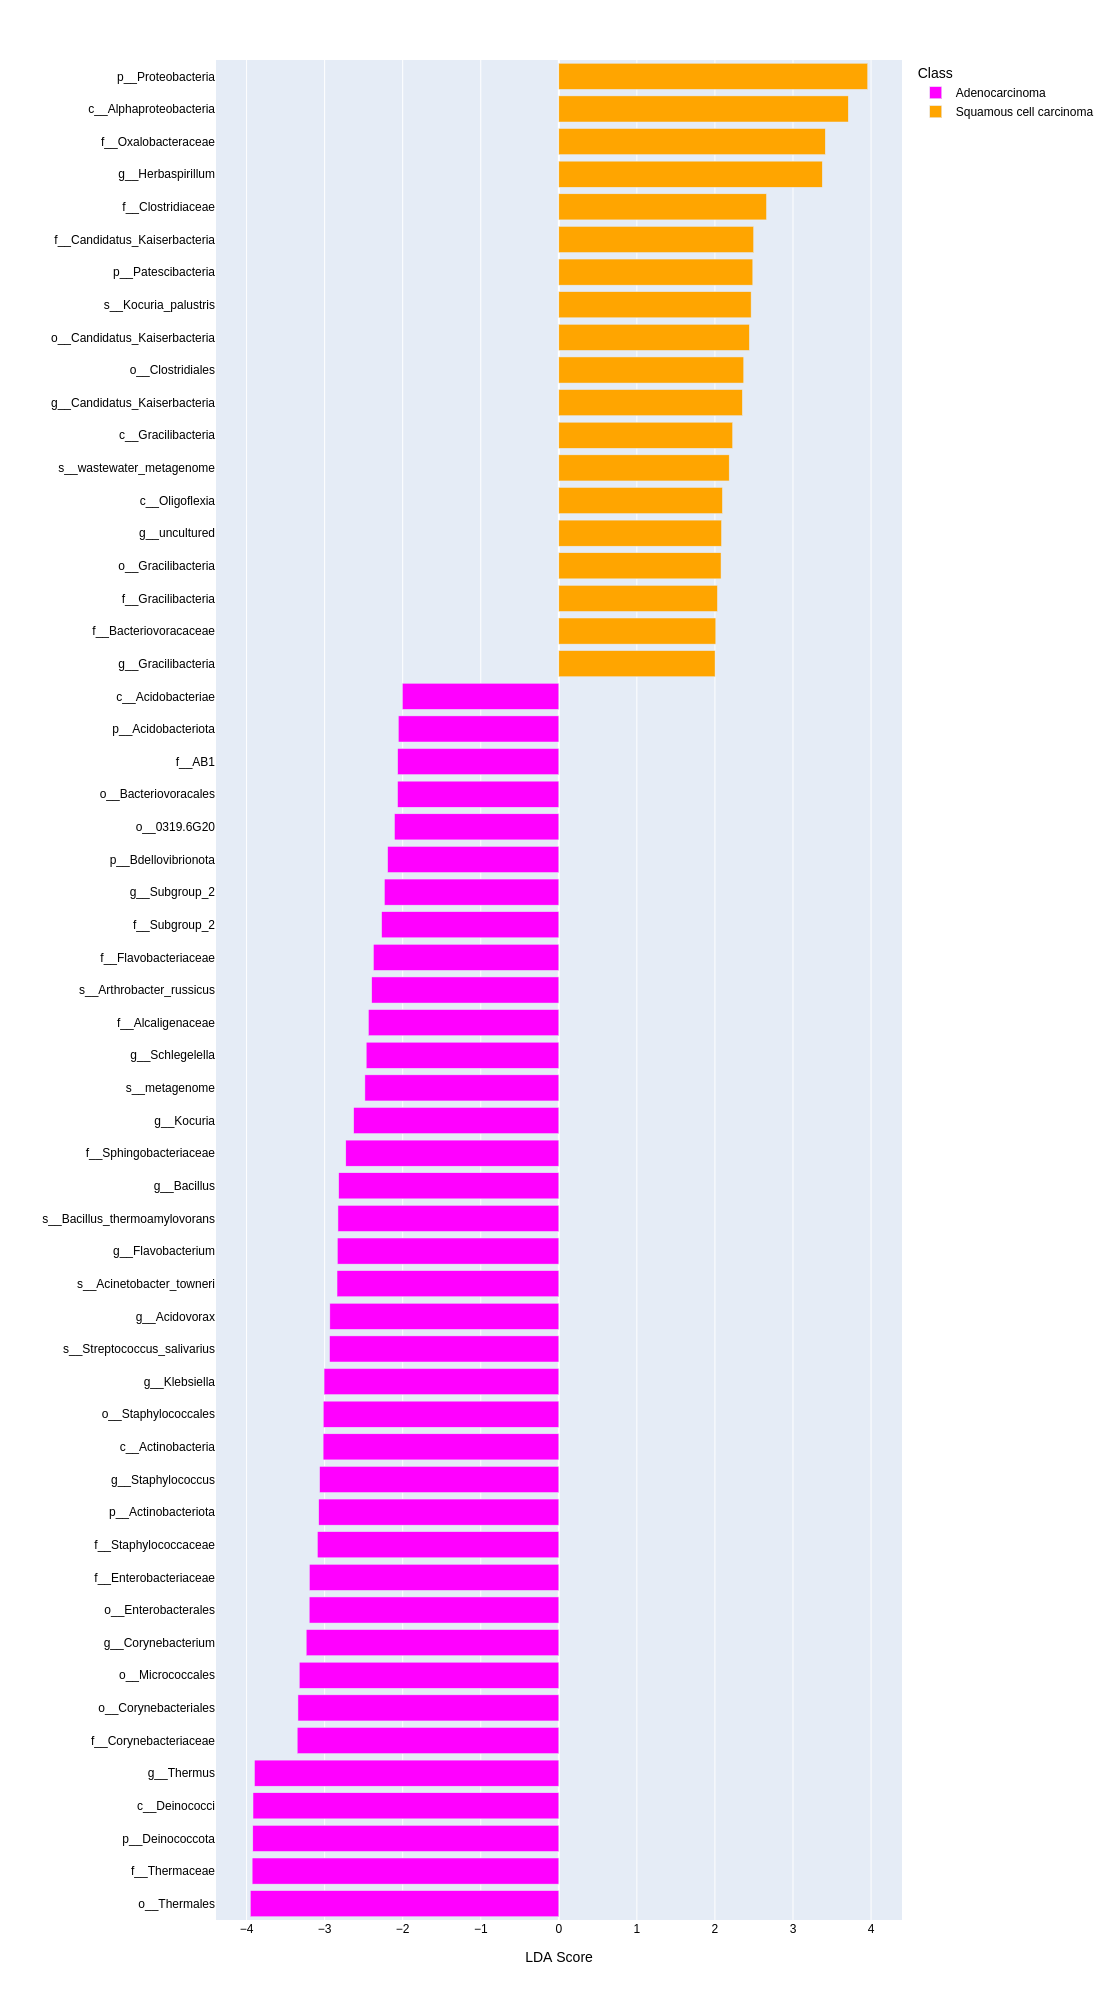

,Names,scores,Class
0,o__Thermales,-3.952377,Adenocarcinoma
1,f__Thermaceae,-3.928856,Adenocarcinoma
2,p__Deinococcota,-3.920416,Adenocarcinoma
3,c__Deinococci,-3.917783,Adenocarcinoma
4,g__Thermus,-3.899157,Adenocarcinoma
5,f__Corynebacteriaceae,-3.351640,Adenocarcinoma
6,o__Corynebacteriales,-3.342046,Adenocarcinoma
7,o__Micrococcales,-3.325516,Adenocarcinoma
8,g__Corynebacterium,-3.236362,Adenocarcinoma
9,o__Enterobacterales,-3.197881,Adenocarcinoma


In [76]:

lefse_data_significant = lefse_data[abs(lefse_data["scores"])>=Lda_threshold]

fig = px.bar(lefse_data_significant, x='scores', y='Names',orientation='h',color="Class",
             hover_name="Class", color_discrete_sequence=["magenta", "orange"],
             labels=dict(Names="", scores="LDA Score"))

fig.update_layout(
    autosize=False,
    width=1200,
    height=2000,
    font_color="black",
   )

fig.show()


fig.write_image("lefse_otu_all.pdf")
fig.write_image("lefse_otu_all.svg")

fig.write_image("lefse_otu_all.png")
lefse_data_significant


Number of statistically significant taxa are:- 74
[' o__Thermales', ' f__Thermaceae', ' p__Deinococcota', ' c__Deinococci', ' g__Thermus', ' f__Corynebacteriaceae', ' o__Corynebacteriales', ' o__Micrococcales', ' g__Corynebacterium', ' o__Enterobacterales', ' f__Enterobacteriaceae', ' f__Staphylococcaceae', ' p__Actinobacteriota', ' g__Staphylococcus', ' c__Actinobacteria', ' o__Staphylococcales', ' g__Klebsiella', ' s__Streptococcus_salivarius', ' g__Acidovorax', ' s__Acinetobacter_towneri', ' g__Flavobacterium', ' s__Bacillus_thermoamylovorans', ' g__Bacillus', ' f__Sphingobacteriaceae', ' g__Kocuria', ' s__metagenome', ' g__Schlegelella', ' f__Alcaligenaceae', ' s__Arthrobacter_russicus', ' f__Flavobacteriaceae', ' f__Subgroup_2', ' g__Subgroup_2', ' p__Bdellovibrionota', ' o__0319-6G20', ' o__Bacteriovoracales', ' f__AB1', ' p__Acidobacteriota', ' c__Acidobacteriae', ' g__AB1', ' g__Arthrobacter', ' g__Achromobacter', ' o__Saccharimonadales', ' g__Saccharimonadales', ' g__0319-6G20

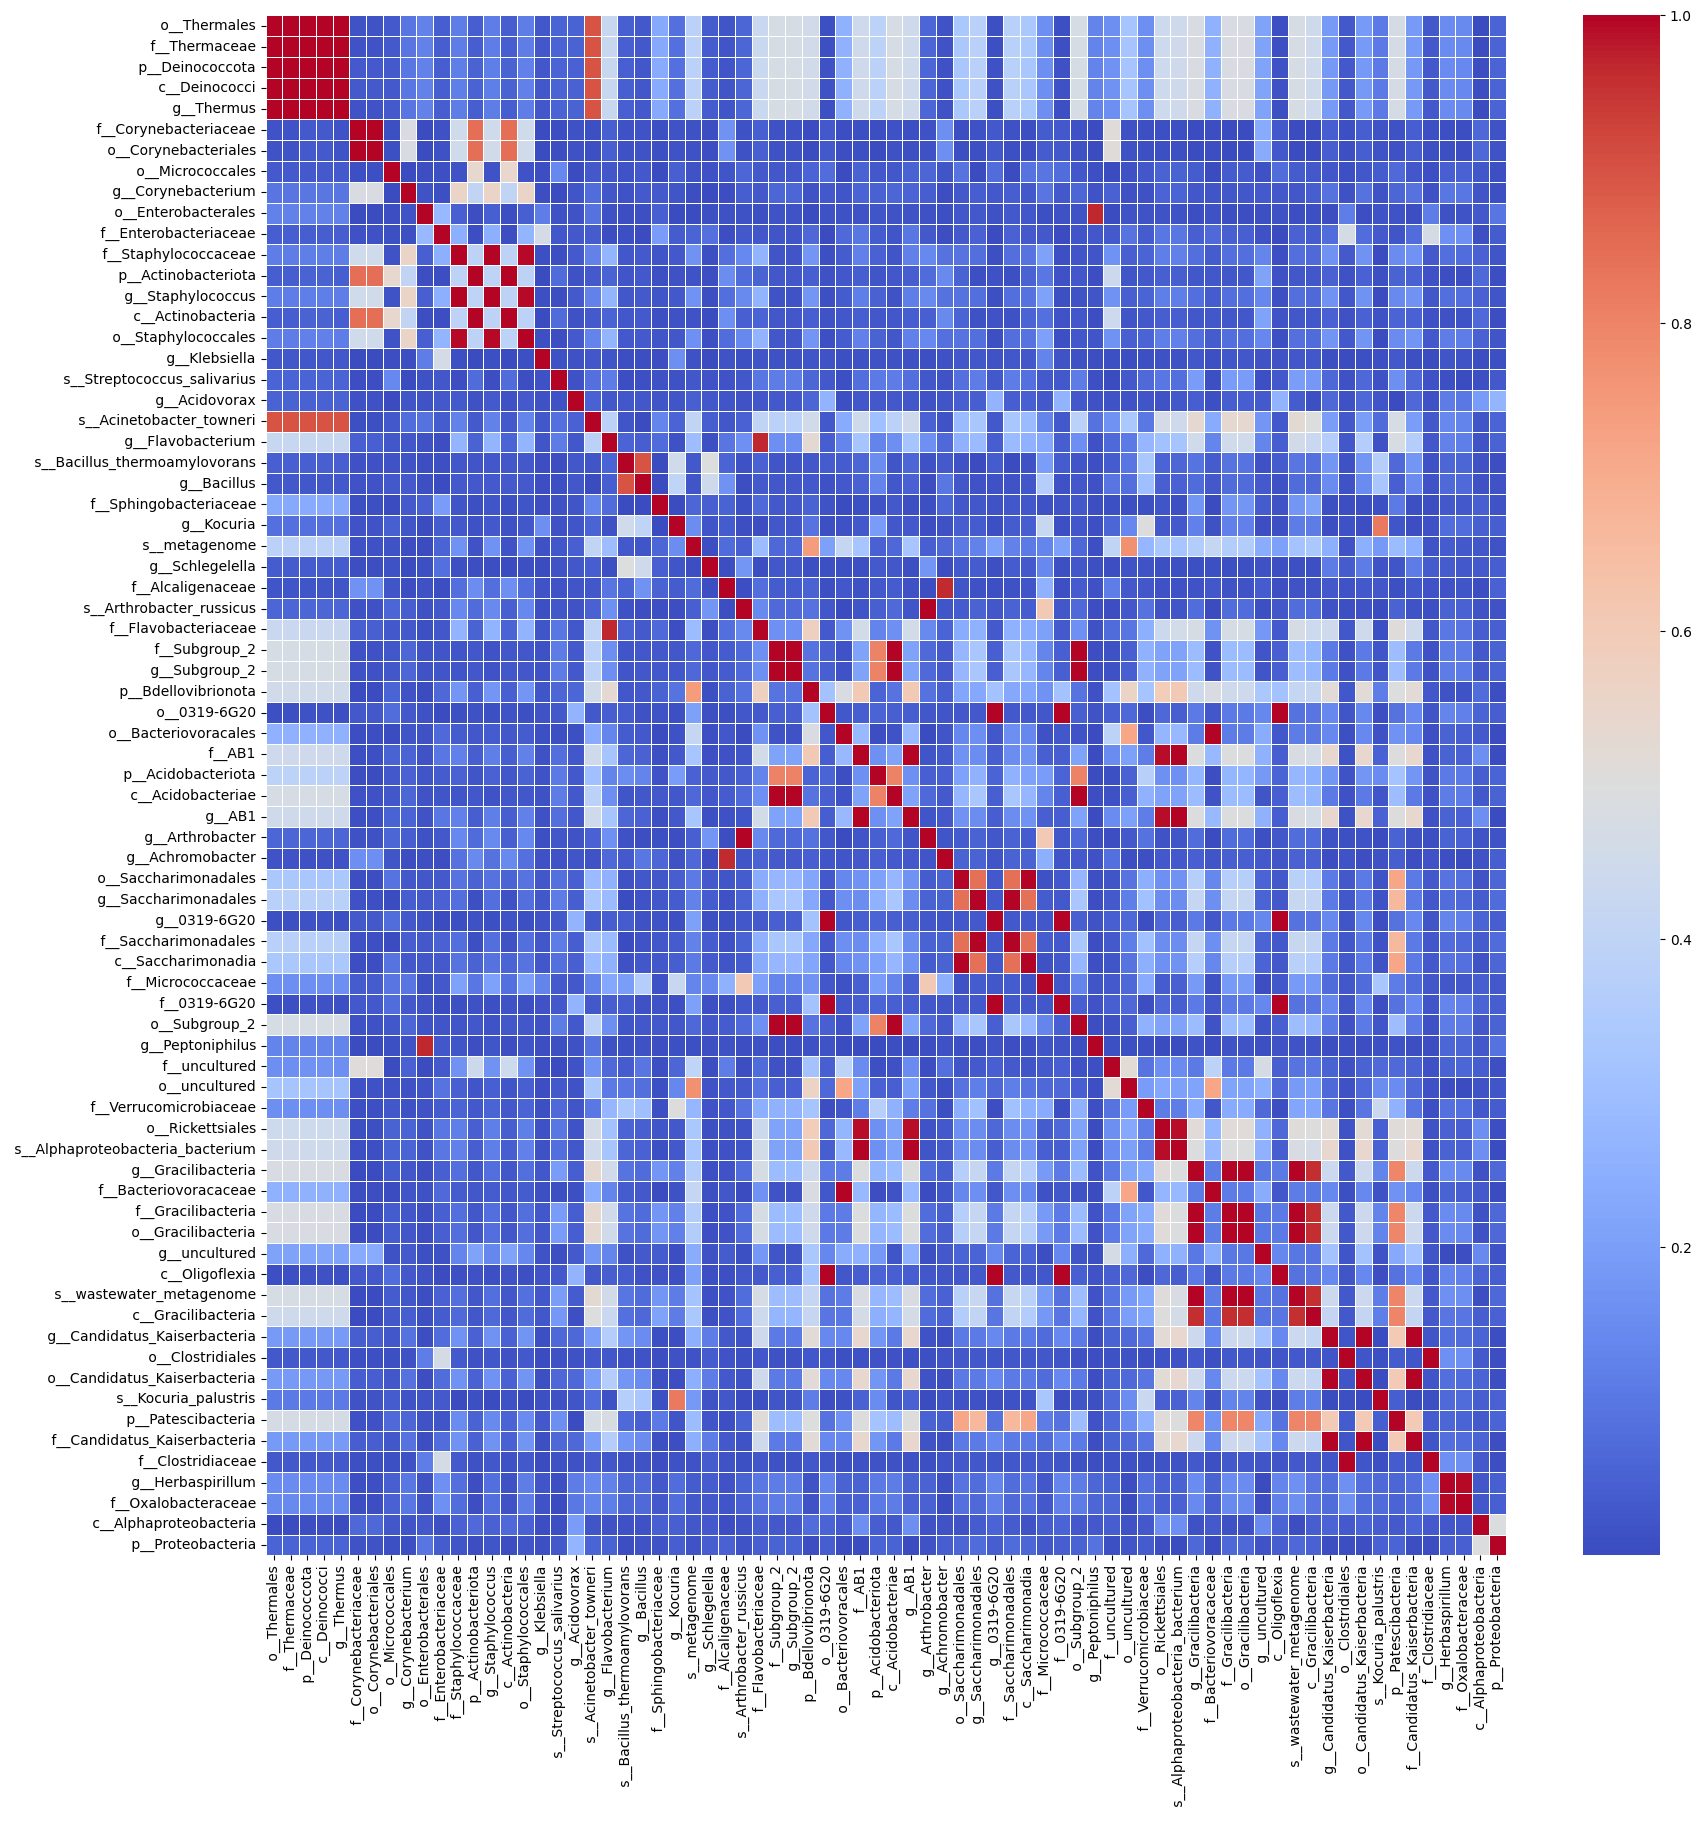

Adenocarcinoma: 32
Squamous cell carcinoma: 12


In [77]:
if top_10_feature_true:
  temp_arr_names=[]

  chosen_taxa=list(lefse_data["Names"])

  print("Number of statistically significant taxa are:-",len(chosen_taxa))

  for i in range(len(chosen_taxa)):
    if (str(chosen_taxa[i])=='g__0319.6G20'):
      temp_arr_names.append(" g__0319-6G20")
    elif (str(chosen_taxa[i])=='f__0319.6G20'):
      temp_arr_names.append(" f__0319-6G20")
    elif (str(chosen_taxa[i])=='o__0319.6G20'):
      temp_arr_names.append(" o__0319-6G20")
    elif (str(chosen_taxa[i])=='g__Escherichia.Shigella'):
      temp_arr_names.append(" g__Escherichia-Shigella")
    else:
      temp_arr_names.append(" "+str(chosen_taxa[i]))

  print(temp_arr_names)
    


  temp_selected_data=comp_data[temp_arr_names]

  temp_features_1 = list(temp_selected_data.columns)

  # Removing highly correlated features
  corr_matrix = temp_selected_data.corr().abs()

  # plot the heatmap
  plt.figure(figsize=(20,20))
  sns.heatmap(corr_matrix, annot=False, linewidth=0.5,  cmap='coolwarm') #fmt=".2f")


  
  # Save the figure in different formats
  plt.savefig("heatmap_correlation.svg", format='svg')  # Save as SVG
  plt.savefig("heatmap_correlation.png", format='png', dpi=1300)  # Save as PNG with high resolution
  plt.savefig("heatmap_correlation.pdf", format='pdf')  # Save as PDF

  # Display the heatmap

  plt.show()
  

  # Select upper triangle of correlation matrix
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

  

  # Find features with correlation greater than 0.95
  to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

  to_drop = [temp.strip() for temp in to_drop]

  #print(f'Number of features removed: {len(to_drop)}')

  # Now make the new lefse_data by removing the highly correlated features
  lefse_data_np = np.array(lefse_data)

  temp_lefse_data = []

  for i in range(len(lefse_data_np)):
      if (lefse_data_np[i][0] not in to_drop):
          temp_lefse_data.append(lefse_data_np[i])

  temp_lefse_data = np.array(temp_lefse_data)

  temp_lefse_data_pd = pd.DataFrame(temp_lefse_data, columns= ["Names", "scores", "Class"])

  lefse_data_adeno = temp_lefse_data_pd[temp_lefse_data_pd["Class"] == "Adenocarcinoma"]
  lefse_data_squamous = temp_lefse_data_pd[temp_lefse_data_pd["Class"] == "Squamous cell carcinoma"]

  print(f'Adenocarcinoma: {len(lefse_data_adeno)}')
  print(f'Squamous cell carcinoma: {len(lefse_data_squamous)}')

  # Sort the data based on the LDA score
  lefse_data_adeno = lefse_data_adeno.sort_values(by=["scores"], ascending=True)
  lefse_data_squamous = lefse_data_squamous.sort_values(by=["scores"], ascending=False)

  # Select the top 10 features
  top_10_adeno = lefse_data_adeno.head(5)
  top_10_squamous = lefse_data_squamous.head(5)

  # Combine the data
  top_10_features = pd.concat([top_10_adeno, top_10_squamous])
  top_10_features 

  lefse_data = top_10_features

In [78]:
fig = px.bar(lefse_data, x='scores', y='Names',orientation='h',color="Class",labels=dict(Names="", scores="LDA Score", Class="Groups"))
pio.write_image(fig, 'plot_all.svg',scale=7, width=800, height=600)
fig.show()

In [79]:

Class="Lung cancer subtypes"

lefse_data_2 = lefse_data[abs(lefse_data["scores"])>=Lda_threshold]

fig = px.bar(lefse_data_2, x='scores', y='Names',orientation='h',color="Class",
             hover_name="Class", color_discrete_sequence=["magenta", "orange"],
             labels=dict(Names="", scores="LDA Score"))

#pio.write_image(fig, 'plot_all_2.svg',scale=7, width=600, height=600)


fig.update_layout(
    autosize=False,
    width=700,
    height=400,
    font_color="black",
   )

fig.show()


fig.write_image("lefse_otu.pdf")
fig.write_image("lefse_otu.svg")

fig.write_image("lefse_otu.png")

fig = px.bar(lefse_data_2, x='scores', y='Names',orientation='h',color="Class",labels=dict(Names="", scores="LDA Score", Class="Groups"))
pio.write_image(fig, 'plot_all_2.svg',scale=7, width=600, height=400)
fig.show()

In [80]:
temp_arr_names=[]

chosen_taxa=list(lefse_data_2["Names"])

print("Number of statistically significant taxa are:-",len(chosen_taxa))

for i in range(len(chosen_taxa)):
  if (str(chosen_taxa[i])=='g__0319.6G20'):
    temp_arr_names.append(" g__0319-6G20")
  elif (str(chosen_taxa[i])=='f__0319.6G20'):
    temp_arr_names.append(" f__0319-6G20")
  elif (str(chosen_taxa[i])=='o__0319.6G20'):
    temp_arr_names.append(" o__0319-6G20")
  elif (str(chosen_taxa[i])=='g__Escherichia.Shigella'):
    temp_arr_names.append(" g__Escherichia-Shigella")
  else:
    temp_arr_names.append(" "+str(chosen_taxa[i]))

print(temp_arr_names)

selected_data=comp_data[temp_arr_names]

temp_features_1 = list(selected_data.columns)

# Removing highly correlated features
corr_matrix = selected_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]

# Drop features
selected_data.drop(to_drop, axis=1, inplace=True)

temp_features_2 = list(selected_data.columns)

print(f'Number of features removed: {len(temp_features_1) - len(temp_features_2)}')

selected_data

Number of statistically significant taxa are:- 10
[' o__Thermales', ' f__Corynebacteriaceae', ' o__Micrococcales', ' g__Corynebacterium', ' o__Enterobacterales', ' p__Proteobacteria', ' c__Alphaproteobacteria', ' g__Herbaspirillum', ' p__Patescibacteria', ' s__Kocuria_palustris']
Number of features removed: 0


/tmp/ipykernel_281749/629062989.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,o__Thermales,f__Corynebacteriaceae,o__Micrococcales,g__Corynebacterium,o__Enterobacterales,p__Proteobacteria,c__Alphaproteobacteria,g__Herbaspirillum,p__Patescibacteria,s__Kocuria_palustris
SRR3991455,0,4,0,4,0,1730,395,71,0,0
SRR3991405,0,0,43,0,3,749,0,0,0,0
SRR3991368,0,2210,3,108,0,1258,325,16,0,0
SRR3991360,0,0,0,0,0,911,78,53,0,0
SRR3991582,0,0,0,0,0,229,111,39,0,0
...,...,...,...,...,...,...,...,...,...,...
SRR3991577,0,0,0,0,5,185,112,5,0,0
SRR3991550,0,0,9,0,0,6578,202,17,0,0
SRR3991353,0,0,0,0,2,303,12,21,0,0
SRR3991513,0,0,11,0,0,613,91,14,123,0


# 4. **Meta Data**

In [81]:
# meta_data.columns

In [82]:
if meta_data is not None:

    meta_data = meta_data[[' Sample_id', 'env_material', 'host_sex', 'smoker', 'Host_Age']]

    le1 = preprocessing.LabelEncoder()
    le2 = preprocessing.LabelEncoder()
    le3 = preprocessing.LabelEncoder()

    meta_data.dropna(inplace=True)

    meta_data["env_material"]=le1.fit_transform(meta_data["env_material"])
    meta_data["host_sex"]=le2.fit_transform(meta_data["host_sex"])
    meta_data["smoker"]=le3.fit_transform(meta_data["smoker"])

    print(f'Unique env_material: {le1.classes_}')
    print(f'Unique host_sex: {le2.classes_}')
    print(f'Unique smoker: {le3.classes_}')

    meta_data_np = np.array(meta_data)

    sample_id_to_meta = {}
    for i in range(len(meta_data_np)):
        sample_id_to_meta[meta_data_np[i, 0]] = meta_data_np[i, 1:]


    # Combining the selected data with the metadata
    # Converting an dictionary to a dataframe
    meta_data = pd.DataFrame.from_dict(sample_id_to_meta, orient='index', columns=['env_material', 'host_sex', 'smoker', 'age'])

    complete_data = pd.merge(selected_data, meta_data, left_index=True, right_index=True)

    complete_data

else:
    complete_data = selected_data

# Adding the labels
temp_labels = comp_data['treatment']

complete_data = pd.merge(complete_data, temp_labels, left_index=True, right_index=True)

complete_data



Unique env_material: ['lung non-malignant tissue' 'lung tumor tissue']
Unique host_sex: ['female' 'male']
Unique smoker: ['never smoker' 'smoker quit for at least 6 months'
 'smoker quit for less than 6 months']


/tmp/ipykernel_281749/1473826963.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_281749/1473826963.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_281749/1473826963.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_281749/1473826963.py:13: SettingWithCopyWarning:


A 

,o__Thermales,f__Corynebacteriaceae,o__Micrococcales,g__Corynebacterium,o__Enterobacterales,p__Proteobacteria,c__Alphaproteobacteria,g__Herbaspirillum,p__Patescibacteria,s__Kocuria_palustris,env_material,host_sex,smoker,age,treatment
SRR3991455,0,4,0,4,0,1730,395,71,0,0,0,1,2,41.94935,1
SRR3991405,0,0,43,0,3,749,0,0,0,0,0,1,1,67.90691,0
SRR3991368,0,2210,3,108,0,1258,325,16,0,0,0,1,2,75.26352,0
SRR3991360,0,0,0,0,0,911,78,53,0,0,0,1,1,70.76797,1
SRR3991582,0,0,0,0,0,229,111,39,0,0,0,1,2,66.57906,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,0,0,0,0,5,185,112,5,0,0,1,1,1,71.50171,1
SRR3991550,0,0,9,0,0,6578,202,17,0,0,1,1,2,71.17864,1
SRR3991353,0,0,0,0,2,303,12,21,0,0,0,1,2,70.15469,0
SRR3991513,0,0,11,0,0,613,91,14,123,0,0,1,1,71.07461,0


# 5. **Data Preprocessing**

## 5.1 Pre-LDA transform

In [83]:
x_data_pd=complete_data.drop(['treatment'],axis=1)

#Normalisation
scaler = preprocessing.MinMaxScaler()

x_data_pd_stan=pd.DataFrame(scaler.fit_transform(x_data_pd),columns=x_data_pd.columns,index=x_data_pd.index)

result_data = copy.deepcopy(x_data_pd_stan)
result_data["label"] = complete_data["treatment"]

result_data

,o__Thermales,f__Corynebacteriaceae,o__Micrococcales,g__Corynebacterium,o__Enterobacterales,p__Proteobacteria,c__Alphaproteobacteria,g__Herbaspirillum,p__Patescibacteria,s__Kocuria_palustris,env_material,host_sex,smoker,age,label
SRR3991455,0.0,0.00181,0.000000,0.004689,0.000000,0.120557,0.172942,0.295833,0.000000,0.0,0.0,1.0,1.0,0.036375,1
SRR3991405,0.0,0.00000,0.029212,0.000000,0.001024,0.052195,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.5,0.698317,0
SRR3991368,0.0,1.00000,0.002038,0.126612,0.000000,0.087666,0.142294,0.066667,0.000000,0.0,0.0,1.0,1.0,0.885918,0
SRR3991360,0.0,0.00000,0.000000,0.000000,0.000000,0.063484,0.034151,0.220833,0.000000,0.0,0.0,1.0,0.5,0.771277,1
SRR3991582,0.0,0.00000,0.000000,0.000000,0.000000,0.015958,0.048599,0.162500,0.000000,0.0,0.0,1.0,1.0,0.664456,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3991577,0.0,0.00000,0.000000,0.000000,0.001707,0.012892,0.049037,0.020833,0.000000,0.0,1.0,1.0,0.5,0.789988,1
SRR3991550,0.0,0.00000,0.006114,0.000000,0.000000,0.458397,0.088441,0.070833,0.000000,0.0,1.0,1.0,1.0,0.781749,1
SRR3991353,0.0,0.00000,0.000000,0.000000,0.000683,0.021115,0.005254,0.087500,0.000000,0.0,0.0,1.0,1.0,0.755638,0
SRR3991513,0.0,0.00000,0.007473,0.000000,0.000000,0.042718,0.039842,0.058333,0.736527,0.0,0.0,1.0,0.5,0.779097,0


In [84]:
result_data_class0=result_data[result_data["label"]==0]
result_data_class1=result_data[result_data["label"]==1]

result_data_class_0_np=np.array(result_data_class0)
result_data_class_1_np=np.array(result_data_class1)

print(np.unique(result_data_class_0_np[:,len(result_data_class_0_np[0])-1]))
print(np.unique(result_data_class_1_np[:,len(result_data_class_1_np[0])-1]))

x_class_0=result_data_class_0_np[:,0:len(result_data_class_0_np[0])-1]
y_class_0=result_data_class_0_np[:,len(result_data_class_0_np[0])-1].astype(int)

x_class_1=result_data_class_1_np[:,0:len(result_data_class_1_np[0])-1]
y_class_1=result_data_class_1_np[:,len(result_data_class_1_np[0])-1].astype(int)

#CLASS 0
x_train_0, x_test_0, y_train_0, y_test_0 = train_test_split(x_class_0, y_class_0, test_size=0.3,shuffle=True, random_state=42)

#CLASS 1
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_class_1, y_class_1, test_size=0.3,shuffle=True, random_state=42)

#Train Data
x_train=np.r_[x_train_0,x_train_1]
y_train=np.r_[y_train_0,y_train_1]

sample_id_train = x_train[:,len(x_train[0])-1]

#Test Data
x_test=np.r_[x_test_0,x_test_1]
y_test=np.r_[y_test_0,y_test_1]

sample_id_test = x_test[:,len(x_test[0])-1]


print("Number of Instances in Training Data of class 0:-",len(x_train_0))
print("Number of Instances in Training Data of class 1:-",len(x_train_1))

print("Number of Instances in Testing Data of class 0:-",len(x_test_0))
print("Number of Instances in Testing Data of class 1:-",len(x_test_1))


[0.]
[1.]
Number of Instances in Training Data of class 0:- 95
Number of Instances in Training Data of class 1:- 88
Number of Instances in Testing Data of class 0:- 41
Number of Instances in Testing Data of class 1:- 39


## 5.2 SFFS

In [85]:
if SFFS_true:
  poly = preprocessing.PolynomialFeatures(degree=1, include_bias=False)

  x_train_poly = poly.fit_transform(x_train)
  x_test_poly = poly.fit_transform(x_test)

  print(f'Shape of the training data: {np.shape(x_train_poly)}')

  col_names = list(complete_data.columns)[:-1]
  print(col_names)

  poly_names=list(poly.get_feature_names_out(col_names))

  model = LogisticRegression()

  sfs=SFS(model,k_features=7,forward=True,floating=False,cv=5,scoring = 'accuracy',n_jobs=-1)
  sfs.fit(x_train_poly,y_train)

  temp_index=sfs.k_feature_idx_
  temp_cols=poly_names
  chosen_features=[]
  for i in range(len(temp_index)):
    chosen_features.append(temp_cols[temp_index[i]])

  print(chosen_features)


  print('CV Score for s:')
  print(sfs.k_score_)

  fig1=plot_sfs(sfs.get_metric_dict())
  plt.show()

  # Changing the x_train, x_test
  x_train = sfs.transform(x_train_poly)
  x_test = sfs.transform(x_test_poly)


## 5.3 After LDA transform

In [86]:
if Lda_trans == True:
    lda =LinearDiscriminantAnalysis().fit(x_train,y_train)

    x_train = lda.transform(x_train)
    x_test = lda.transform(x_test)
    plt.scatter(x_train,y_train.reshape(-1,1),c=y_train.reshape(-1,1))
    # plt.savefig("lda_plot.pdf",dpi=1200)
    # plt.savefig("lda_plot.svg")
    plt.show()

    plt.scatter(x_train[y_train==0],y_train.reshape(-1,1)[y_train==0],c='magenta',label="AC")
    plt.scatter(x_train[y_train==1],y_train.reshape(-1,1)[y_train==1],c='orange',label="SCC")
    plt.legend()
    #plt.ylabel("Class Label")
    # plt.savefig("lda_before.pdf",dpi=1200)
    # plt.savefig("lda_before.svg")
    # plt.savefig("lda_before.png")
    plt.show()

    plt.scatter(x_train,np.zeros((len(x_train),1)),c=y_train.reshape(-1,1),alpha=0.5)
    # plt.savefig("lda_after.svg")
    plt.show()

    plt.scatter(x_train[y_train==0],np.zeros((len(x_train[y_train==0]),1)),c='magenta',label="AC")
    plt.scatter(x_train[y_train==1],np.zeros((len(x_train[y_train==1]),1)),c='orange',label="SCC")
    plt.legend()
    plt.savefig("lda_after.pdf",dpi=1200)
    plt.savefig("lda_after.svg")
    plt.savefig("lda_after.png")
    plt.show()

    class_0_train_samples = x_train[y_train==0]
    class_1_train_samples = x_train[y_train==1]


    sns.histplot({'AC': class_0_train_samples.ravel(), 'SCC': class_1_train_samples.ravel()}, bins=70, palette=['magenta', 'orange'], kde=True, stat='density')
    plt.savefig("lda hist.png")
    plt.show()






# 6. **Model Building**

## 6.1 Logistic Regression

### 6.1.1 Degree = 1

Training Accuracy is:- 0.6885245901639344
Classification Accuracy is:- 0.725
                precision    recall  f1-score   support

Adenocarcinoma       0.66      0.98      0.78        41
      Squamous       0.95      0.46      0.62        39

      accuracy                           0.72        80
     macro avg       0.80      0.72      0.70        80
  weighted avg       0.80      0.72      0.70        80



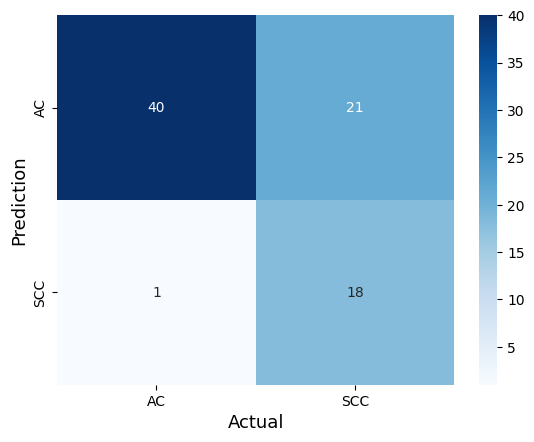

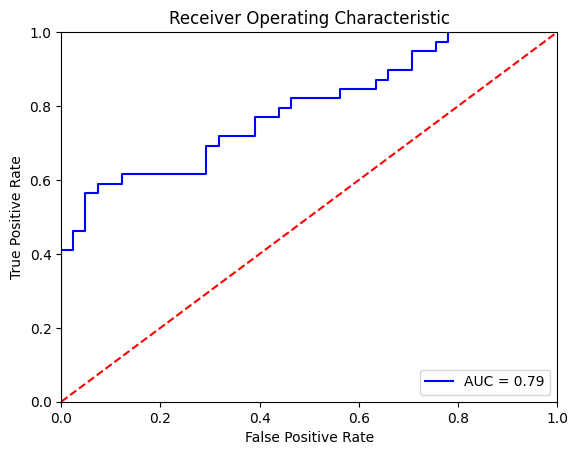

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708201
np.random.seed(RANDOM_SEED)


model_lr_1 = LogisticRegression(random_state=0,C=0.1).fit(x_train,y_train)
y_pred_lr=model_lr_1.predict(x_test)


print("Training Accuracy is:-",model_lr_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_lr_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_lr,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("LR1_confusion_matrix.svg", format='svg')
plt.show()



#ROC Curve
probs = model_lr_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## 6.2 Gaussian Naive Bayes

### 6.2.1 Degree = 1

Training Accuracy is:- 0.546448087431694
Classification Accuracy is:- 0.6
                precision    recall  f1-score   support

Adenocarcinoma       0.91      0.24      0.38        41
      Squamous       0.55      0.97      0.70        39

      accuracy                           0.60        80
     macro avg       0.73      0.61      0.54        80
  weighted avg       0.73      0.60      0.54        80



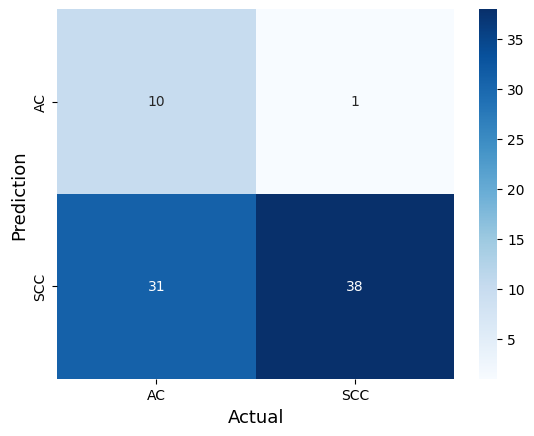

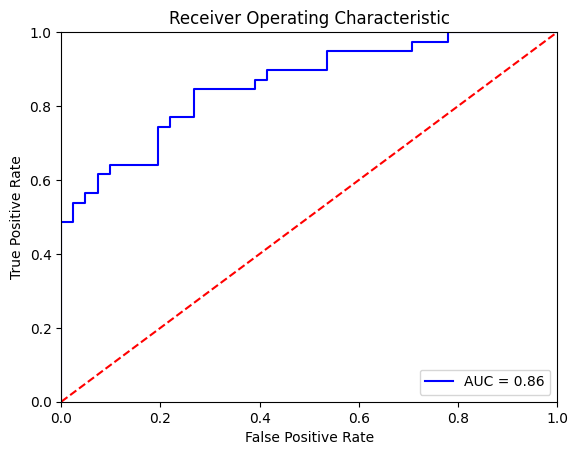

In [88]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708202
np.random.seed(RANDOM_SEED)

model_nb_1 = GaussianNB().fit(x_train,y_train)
y_pred_nb=model_nb_1.predict(x_test)

print("Training Accuracy is:-",model_nb_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_nb_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_nb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("NB1_confusion_matrix.svg", format='svg')

plt.show()

#ROC Curve
probs = model_nb_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 6.3 Random Forest 

## 6.3.1 Degree 1

In [89]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708200
np.random.seed(RANDOM_SEED)
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)


def objective(trial):

  temp_acc = []

  max_depth = trial.suggest_int("max_depth", 1, 10)

  min_samples_split = trial.suggest_int("min_samples_split",2,50)

  min_samples_leaf = trial.suggest_int("min_samples_leaf",1,50)

  max_leaf_nodes = trial.suggest_int("max_leaf_nodes",5,100)

  n_estimators = trial.suggest_int("n_estimators",10,100)

  #K-fold stratified Split
  for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    y_train_temp = y_train[train_index]
    x_train_temp = x_train[train_index]

    y_val_temp = y_train[test_index]
    x_val_temp = x_train[test_index]

    model = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes = max_leaf_nodes,n_estimators=n_estimators,random_state=42)

    #Training the Model
    model.fit(x_train_temp,y_train_temp.ravel())

    y_pred = model.predict(x_val_temp)

    v0 = metrics.accuracy_score(y_val_temp, y_pred)

    temp_acc.append(v0)

  return np.array(temp_acc).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)


[I 2024-12-07 00:39:22,864] A new study created in memory with name: no-name-16968b4b-4b8a-406d-b655-1a8419c29034
[I 2024-12-07 00:39:23,212] Trial 0 finished with value: 0.5788288288288289 and parameters: {'max_depth': 9, 'min_samples_split': 32, 'min_samples_leaf': 41, 'max_leaf_nodes': 55, 'n_estimators': 54}. Best is trial 0 with value: 0.5788288288288289.
[I 2024-12-07 00:39:23,783] Trial 1 finished with value: 0.6831831831831832 and parameters: {'max_depth': 1, 'min_samples_split': 16, 'min_samples_leaf': 10, 'max_leaf_nodes': 18, 'n_estimators': 96}. Best is trial 1 with value: 0.6831831831831832.
[I 2024-12-07 00:39:24,025] Trial 2 finished with value: 0.6393393393393394 and parameters: {'max_depth': 7, 'min_samples_split': 34, 'min_samples_leaf': 18, 'max_leaf_nodes': 8, 'n_estimators': 39}. Best is trial 1 with value: 0.6831831831831832.
[I 2024-12-07 00:39:24,591] Trial 3 finished with value: 0.6012012012012012 and parameters: {'max_depth': 8, 'min_samples_split': 46, 'min_s

{'max_depth': 1, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_leaf_nodes': 20, 'n_estimators': 88}


Training Accuracy is:- 0.7486338797814208
Classification Accuracy is:- 0.7375
                precision    recall  f1-score   support

Adenocarcinoma       0.69      0.88      0.77        41
      Squamous       0.82      0.59      0.69        39

      accuracy                           0.74        80
     macro avg       0.76      0.73      0.73        80
  weighted avg       0.76      0.74      0.73        80



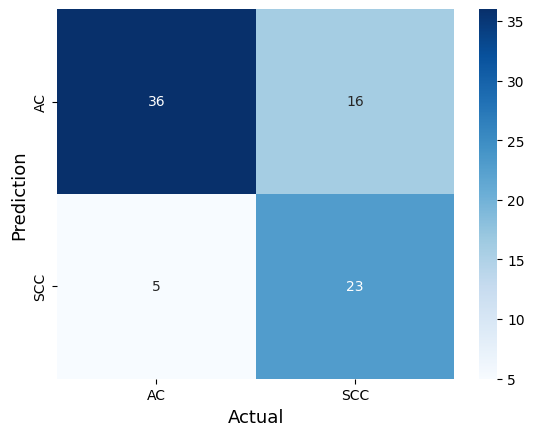

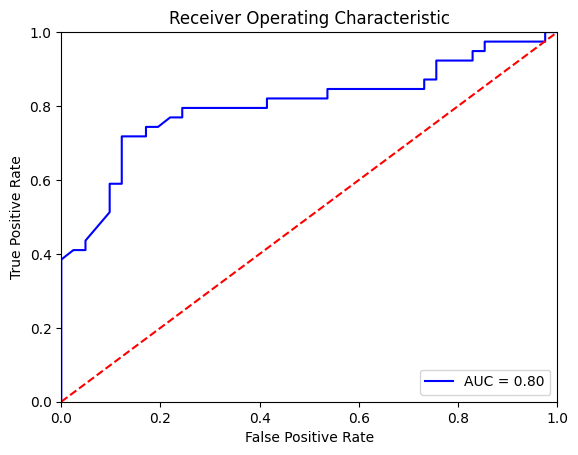

In [90]:
temp_dict = study.best_params

max_depth = 1

min_samples_split = 10

min_samples_leaf = 10

max_leaf_nodes = 4

n_estimators = 60

#max_depth = temp_dict["max_depth"]

#min_samples_split = temp_dict["min_samples_split"]

#min_samples_leaf = temp_dict["min_samples_leaf"]

#max_leaf_nodes = temp_dict["max_leaf_nodes"]

#n_estimators = temp_dict["n_estimators"]

model_rfc_1 = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes = max_leaf_nodes,n_estimators=n_estimators,random_state=42).fit(x_train,y_train)
y_pred_rfc=model_rfc_1.predict(x_test)


print("Training Accuracy is:-",model_rfc_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_rfc_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_rfc, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_rfc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)


# Save the confusion matrix as an SVG file
plt.savefig("RF1_confusion_matrix.svg", format='svg')

plt.show()

#ROC Curve
probs = model_rfc_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 6.5 XGBoost Classifier

### 6.5.1 Degree = 1

In [91]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708206
np.random.seed(RANDOM_SEED)

def objective(trial):

  temp_acc = []

  max_depth = trial.suggest_int("max_depth", 1, 10)

  #K-fold stratified Split
  for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    y_train_temp = y_train[train_index]
    x_train_temp = x_train[train_index]

    y_val_temp = y_train[test_index]
    x_val_temp = x_train[test_index]

    model = XGBClassifier(max_depth=max_depth,random_state=42)

    #Training the Model
    model.fit(x_train_temp,y_train_temp.ravel())

    y_pred = model.predict(x_val_temp)

    v0 = metrics.accuracy_score(y_val_temp, y_pred)
    temp_acc.append(v0)

  return np.array(temp_acc).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)


[I 2024-12-07 00:40:11,766] A new study created in memory with name: no-name-cc5f64bb-0395-457b-a3a2-ab34efbe4004
[I 2024-12-07 00:40:12,315] Trial 0 finished with value: 0.6064564564564564 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.6064564564564564.
[I 2024-12-07 00:40:12,750] Trial 1 finished with value: 0.6012012012012012 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.6064564564564564.
[I 2024-12-07 00:40:13,348] Trial 2 finished with value: 0.6177177177177178 and parameters: {'max_depth': 2}. Best is trial 2 with value: 0.6177177177177178.
[I 2024-12-07 00:40:13,610] Trial 3 finished with value: 0.6177177177177178 and parameters: {'max_depth': 2}. Best is trial 2 with value: 0.6177177177177178.
[I 2024-12-07 00:40:14,027] Trial 4 finished with value: 0.6007507507507508 and parameters: {'max_depth': 8}. Best is trial 2 with value: 0.6177177177177178.
[I 2024-12-07 00:40:14,402] Trial 5 finished with value: 0.5845345345345345 and parameters: {'ma

{'max_depth': 1}


Training Accuracy is:- 0.8087431693989071
Classification Accuracy is:- 0.7625
                precision    recall  f1-score   support

Adenocarcinoma       0.74      0.83      0.78        41
      Squamous       0.79      0.69      0.74        39

      accuracy                           0.76        80
     macro avg       0.77      0.76      0.76        80
  weighted avg       0.77      0.76      0.76        80



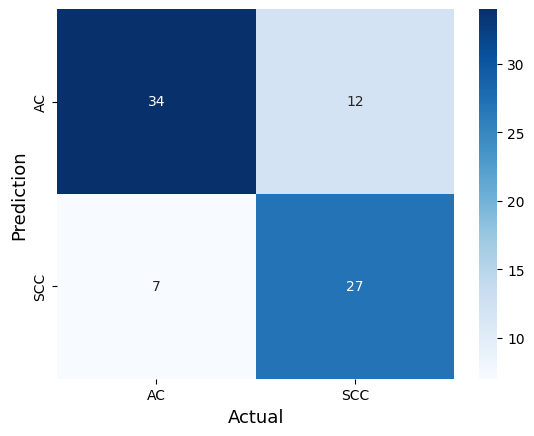

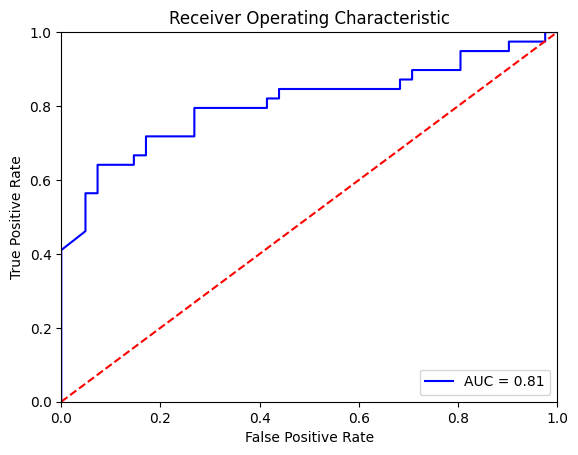

In [92]:
temp_dict = study.best_params

max_depth = temp_dict["max_depth"]

model_xgb_1 = XGBClassifier(max_depth=max_depth,random_state=42).fit(x_train,y_train)
y_pred_xgb=model_xgb_1.predict(x_test)

print("Training Accuracy is:-",model_xgb_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_xgb_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

dat_lr=confusion_matrix(y_pred_xgb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("XGB1_confusion_matrix.svg", format='svg')

plt.show()

probs = model_xgb_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 6.7 KNN Classifier

### 6.7.1 Degree = 1

In [93]:

# Set the random seed
RANDOM_SEED = 1708200
np.random.seed(RANDOM_SEED)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def objective(trial):

    temp_acc = []

    # Define hyperparameters to tune for KNN
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 2)

    # K-fold stratified split
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_temp = x_train[train_index]
        y_train_temp = y_train[train_index]
        x_val_temp = x_train[test_index]
        y_val_temp = y_train[test_index]

        model = KNeighborsClassifier(
            n_neighbors=n_neighbors,
            weights=weights,
            p=p
        )

        # Training the Model
        model.fit(x_train_temp, y_train_temp.ravel())

        y_pred = model.predict(x_val_temp)
        v0 = metrics.accuracy_score(y_val_temp, y_pred)

        temp_acc.append(v0)

    return np.array(temp_acc).mean()

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)


[I 2024-12-07 00:40:39,484] A new study created in memory with name: no-name-7a8e6373-31e2-4875-9885-378ab81cad9d
[I 2024-12-07 00:40:39,499] Trial 0 finished with value: 0.6336336336336337 and parameters: {'n_neighbors': 39, 'weights': 'distance', 'p': 1}. Best is trial 0 with value: 0.6336336336336337.
[I 2024-12-07 00:40:39,524] Trial 1 finished with value: 0.6117117117117118 and parameters: {'n_neighbors': 39, 'weights': 'uniform', 'p': 1}. Best is trial 0 with value: 0.6336336336336337.
[I 2024-12-07 00:40:39,537] Trial 2 finished with value: 0.639039039039039 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'p': 1}. Best is trial 2 with value: 0.639039039039039.
[I 2024-12-07 00:40:39,562] Trial 3 finished with value: 0.6283783783783784 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'p': 2}. Best is trial 2 with value: 0.639039039039039.
[I 2024-12-07 00:40:39,588] Trial 4 finished with value: 0.628078078078078 and parameters: {'n_neighbors': 28, 'weights': '

{'n_neighbors': 1, 'weights': 'distance', 'p': 2}


Training Accuracy is:- 1.0
Classification Accuracy is:- 0.6
                precision    recall  f1-score   support

Adenocarcinoma       0.63      0.54      0.58        41
      Squamous       0.58      0.67      0.62        39

      accuracy                           0.60        80
     macro avg       0.60      0.60      0.60        80
  weighted avg       0.60      0.60      0.60        80



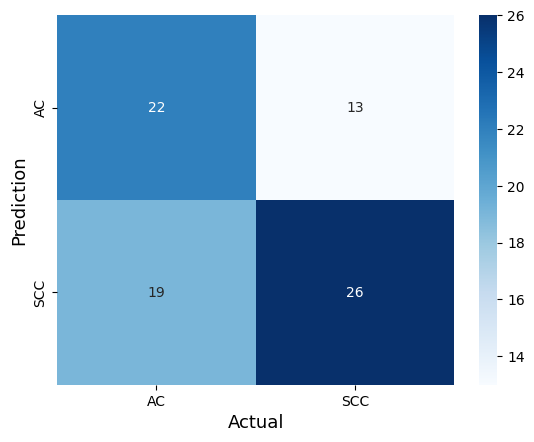

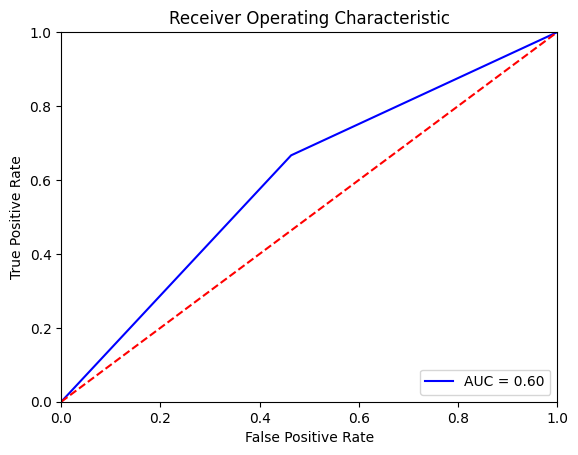

In [94]:
temp_dict = study.best_params
n_neighbors = temp_dict["n_neighbors"]
weights = temp_dict["weights"]
p = temp_dict["p"]

model_knn_1 = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights,p=p).fit(x_train,y_train)
y_pred_knn=model_knn_1.predict(x_test)

print("Training Accuracy is:-",model_knn_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_knn_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_knn, target_names=target_names))

dat_lr=confusion_matrix(y_pred_knn,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("KNN1_confusion_matrix.svg", format='svg')

plt.show()

probs = model_knn_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 6.10 Sk-learn Neural Network Optimisation

### 6.10.1 Degree = 1

In [95]:


# Set the random seed
RANDOM_SEED = 1708200
np.random.seed(RANDOM_SEED)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def objective(trial):
    temp_acc = []

    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = [trial.suggest_int(f"Num Hidden_{i}", 1, 500) for i in range(n_layers)]

    # L2 Regularization term
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 2000)
    tol = trial.suggest_float("tol", 1e-5, 1e-3, log=True)

    # K-fold stratified Split
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_temp, x_val_temp = x_train[train_index], x_train[test_index]
        y_train_temp, y_val_temp = y_train[train_index], y_train[test_index]

        model = MLPClassifier(
            hidden_layer_sizes=layers,
            alpha=alpha,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            tol=tol,
            early_stopping=True,
            validation_fraction=0.3,
            random_state=RANDOM_SEED
        )

        # Training the Model
        model.fit(x_train_temp, y_train_temp.ravel())

        y_pred = model.predict(x_val_temp)
        acc = metrics.accuracy_score(y_val_temp, y_pred)
        temp_acc.append(acc)

    return np.mean(temp_acc)

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best parameters:")
print(study.best_params)


[I 2024-12-07 00:40:42,062] A new study created in memory with name: no-name-09cf3e97-6a14-4387-8564-537460f8f8ad
[I 2024-12-07 00:40:42,258] Trial 0 finished with value: 0.5355855855855856 and parameters: {'n_layers': 1, 'Num Hidden_0': 443, 'alpha': 0.0074710844959593485, 'learning_rate': 'adaptive', 'learning_rate_init': 2.9209243105898128e-05, 'max_iter': 231, 'tol': 0.0007455703670557088}. Best is trial 0 with value: 0.5355855855855856.
[I 2024-12-07 00:40:43,069] Trial 1 finished with value: 0.639039039039039 and parameters: {'n_layers': 2, 'Num Hidden_0': 338, 'Num Hidden_1': 441, 'alpha': 1.3977313101014784e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.0003659068876245638, 'max_iter': 1832, 'tol': 8.936910720395965e-05}. Best is trial 1 with value: 0.639039039039039.
[I 2024-12-07 00:40:47,472] Trial 2 finished with value: 0.6391891891891893 and parameters: {'n_layers': 5, 'Num Hidden_0': 218, 'Num Hidden_1': 445, 'Num Hidden_2': 402, 'Num Hidden_3': 151, 'Num Hidde

Best parameters:
{'n_layers': 5, 'Num Hidden_0': 228, 'Num Hidden_1': 240, 'Num Hidden_2': 80, 'Num Hidden_3': 63, 'Num Hidden_4': 224, 'alpha': 0.0010245239528192836, 'learning_rate': 'constant', 'learning_rate_init': 0.0016281021863707528, 'max_iter': 382, 'tol': 9.759169766156164e-05}


Accuracy on the training data is:- 0.73224043715847
Classification Accuracy is:- 0.75
                precision    recall  f1-score   support

Adenocarcinoma       0.68      0.95      0.80        41
      Squamous       0.91      0.54      0.68        39

      accuracy                           0.75        80
     macro avg       0.80      0.74      0.74        80
  weighted avg       0.80      0.75      0.74        80



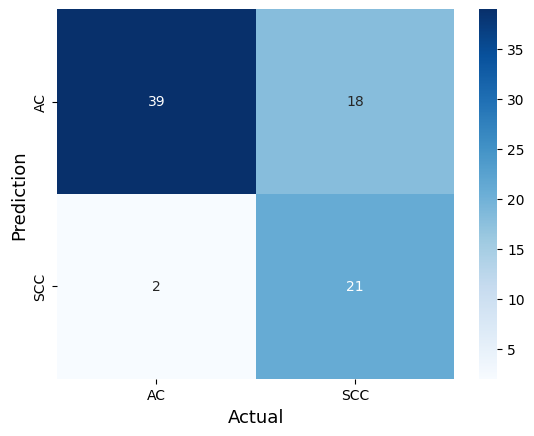

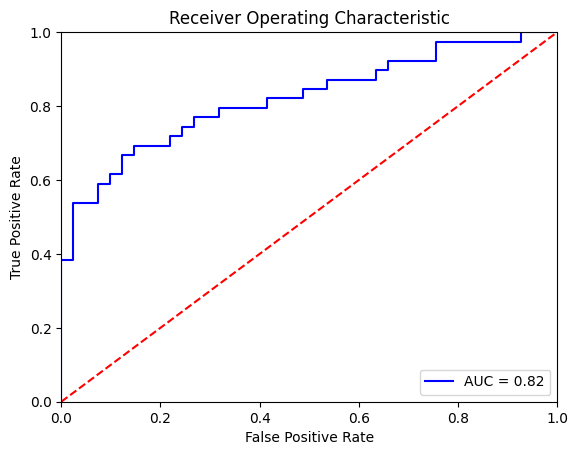

In [96]:
temp_dict = study.best_params

n_layers = temp_dict["n_layers"]

layers = []

for i in range(n_layers):
  hidden_neuron = temp_dict["Num Hidden_"+str(i)]
  layers.append(hidden_neuron)


#L2 Regularisation term
alpha = temp_dict["alpha"]

learning_rate = temp_dict["learning_rate"]

learning_rate_init = temp_dict["learning_rate_init"]

max_iter = temp_dict["max_iter"]

tol = temp_dict["tol"]


model_nn_1 = MLPClassifier(hidden_layer_sizes=layers , alpha = alpha, learning_rate= learning_rate, learning_rate_init= learning_rate_init, max_iter= max_iter,tol=tol,early_stopping=True,validation_fraction=0.3 ,random_state=42)


#Training the Model
model_nn_1.fit(x_train,y_train.ravel())

y_pred_nn=model_nn_1.predict(x_test)

print("Accuracy on the training data is:-",model_nn_1.score(x_train,y_train))
print("Classification Accuracy is:-",model_nn_1.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_nn, target_names=target_names))


dat_lr=confusion_matrix(y_pred_nn,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("DNN1_confusion_matrix.svg", format='svg')

plt.show()

probs = model_nn_1.predict_proba(x_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [98]:
#pip install shap

[I 2024-12-07 00:43:53,150] A new study created in memory with name: no-name-00e0f52f-673a-43d5-b701-eb572f4b35c8
[I 2024-12-07 00:43:53,879] Trial 0 finished with value: 0.6382882882882882 and parameters: {'n_layers': 2, 'Num Hidden_0': 285, 'Num Hidden_1': 75, 'alpha': 0.00011050987765775011, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0009476417230454821, 'max_iter': 184, 'tol': 4.877004868488569e-05}. Best is trial 0 with value: 0.6382882882882882.
[I 2024-12-07 00:43:54,037] Trial 1 finished with value: 0.5297297297297298 and parameters: {'n_layers': 1, 'Num Hidden_0': 203, 'alpha': 3.0954741682923576e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00036108559222103944, 'max_iter': 259, 'tol': 3.003258824623062e-05}. Best is trial 0 with value: 0.6382882882882882.


Trial 0: Accuracy = 0.6382882882882882
Trial 1: Accuracy = 0.5297297297297298


[I 2024-12-07 00:43:55,577] Trial 2 finished with value: 0.48078078078078085 and parameters: {'n_layers': 4, 'Num Hidden_0': 332, 'Num Hidden_1': 241, 'Num Hidden_2': 136, 'Num Hidden_3': 177, 'alpha': 1.2057487309578659e-05, 'learning_rate': 'invscaling', 'learning_rate_init': 7.326884403122179e-05, 'max_iter': 264, 'tol': 3.421121016444237e-05}. Best is trial 0 with value: 0.6382882882882882.


Trial 2: Accuracy = 0.48078078078078085


[I 2024-12-07 00:43:58,772] Trial 3 finished with value: 0.6334834834834835 and parameters: {'n_layers': 4, 'Num Hidden_0': 263, 'Num Hidden_1': 96, 'Num Hidden_2': 301, 'Num Hidden_3': 241, 'alpha': 0.00010759913885447171, 'learning_rate': 'adaptive', 'learning_rate_init': 0.08838678179765576, 'max_iter': 316, 'tol': 0.0003302863626647307}. Best is trial 0 with value: 0.6382882882882882.


Trial 3: Accuracy = 0.6334834834834835


[I 2024-12-07 00:44:00,968] Trial 4 finished with value: 0.6219219219219219 and parameters: {'n_layers': 3, 'Num Hidden_0': 365, 'Num Hidden_1': 343, 'Num Hidden_2': 473, 'alpha': 1.3403918248782245e-05, 'learning_rate': 'constant', 'learning_rate_init': 0.007257602326759153, 'max_iter': 202, 'tol': 0.000314308506208875}. Best is trial 0 with value: 0.6382882882882882.


Trial 4: Accuracy = 0.6219219219219219


[I 2024-12-07 00:44:01,209] Trial 5 finished with value: 0.47522522522522526 and parameters: {'n_layers': 3, 'Num Hidden_0': 78, 'Num Hidden_1': 27, 'Num Hidden_2': 167, 'alpha': 0.002003965296492542, 'learning_rate': 'adaptive', 'learning_rate_init': 3.767987386464179e-05, 'max_iter': 183, 'tol': 1.9028915264456254e-05}. Best is trial 0 with value: 0.6382882882882882.


Trial 5: Accuracy = 0.47522522522522526


[I 2024-12-07 00:44:02,032] Trial 6 finished with value: 0.6716216216216216 and parameters: {'n_layers': 4, 'Num Hidden_0': 137, 'Num Hidden_1': 339, 'Num Hidden_2': 16, 'Num Hidden_3': 298, 'alpha': 0.0013048933134765565, 'learning_rate': 'adaptive', 'learning_rate_init': 0.015443128866961827, 'max_iter': 166, 'tol': 3.4112178239816144e-05}. Best is trial 6 with value: 0.6716216216216216.
[I 2024-12-07 00:44:02,168] Trial 7 finished with value: 0.48078078078078085 and parameters: {'n_layers': 3, 'Num Hidden_0': 51, 'Num Hidden_1': 44, 'Num Hidden_2': 13, 'alpha': 1.0203414025533106e-05, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0002696588343193499, 'max_iter': 345, 'tol': 0.00019619787592740014}. Best is trial 6 with value: 0.6716216216216216.


Trial 6: Accuracy = 0.6716216216216216
Trial 7: Accuracy = 0.48078078078078085


[I 2024-12-07 00:44:02,278] Trial 8 finished with value: 0.6663663663663664 and parameters: {'n_layers': 1, 'Num Hidden_0': 80, 'alpha': 0.0010565383923128776, 'learning_rate': 'constant', 'learning_rate_init': 0.0060326161722412345, 'max_iter': 236, 'tol': 0.00011230753168955314}. Best is trial 6 with value: 0.6716216216216216.


Trial 8: Accuracy = 0.6663663663663664


[I 2024-12-07 00:44:03,440] Trial 9 finished with value: 0.6608108108108108 and parameters: {'n_layers': 4, 'Num Hidden_0': 145, 'Num Hidden_1': 270, 'Num Hidden_2': 339, 'Num Hidden_3': 111, 'alpha': 0.007772593966103259, 'learning_rate': 'constant', 'learning_rate_init': 0.0002854362380345662, 'max_iter': 258, 'tol': 0.0009427274930468818}. Best is trial 6 with value: 0.6716216216216216.


Trial 9: Accuracy = 0.6608108108108108


[I 2024-12-07 00:44:04,320] Trial 10 finished with value: 0.5192192192192191 and parameters: {'n_layers': 5, 'Num Hidden_0': 494, 'Num Hidden_1': 471, 'Num Hidden_2': 1, 'Num Hidden_3': 492, 'Num Hidden_4': 1, 'alpha': 0.0005797573626131626, 'learning_rate': 'adaptive', 'learning_rate_init': 0.09493498499234365, 'max_iter': 60, 'tol': 1.1525735418597682e-05}. Best is trial 6 with value: 0.6716216216216216.
[I 2024-12-07 00:44:04,476] Trial 11 finished with value: 0.5405405405405406 and parameters: {'n_layers': 1, 'Num Hidden_0': 9, 'alpha': 0.0009960718061746614, 'learning_rate': 'constant', 'learning_rate_init': 0.009149092358816162, 'max_iter': 499, 'tol': 9.566635010018977e-05}. Best is trial 6 with value: 0.6716216216216216.


Trial 10: Accuracy = 0.5192192192192191
Trial 11: Accuracy = 0.5405405405405406


[I 2024-12-07 00:44:05,248] Trial 12 finished with value: 0.6444444444444445 and parameters: {'n_layers': 2, 'Num Hidden_0': 140, 'Num Hidden_1': 480, 'alpha': 0.005431132246391205, 'learning_rate': 'constant', 'learning_rate_init': 0.008596440608052515, 'max_iter': 69, 'tol': 7.072232074606761e-05}. Best is trial 6 with value: 0.6716216216216216.


Trial 12: Accuracy = 0.6444444444444445


[I 2024-12-07 00:44:08,021] Trial 13 finished with value: 0.6716216216216215 and parameters: {'n_layers': 5, 'Num Hidden_0': 128, 'Num Hidden_1': 366, 'Num Hidden_2': 133, 'Num Hidden_3': 413, 'Num Hidden_4': 492, 'alpha': 0.0022298978034300315, 'learning_rate': 'adaptive', 'learning_rate_init': 0.024873902154740796, 'max_iter': 129, 'tol': 0.00013536093831368189}. Best is trial 6 with value: 0.6716216216216216.


Trial 13: Accuracy = 0.6716216216216215


[I 2024-12-07 00:44:11,104] Trial 14 finished with value: 0.6936936936936936 and parameters: {'n_layers': 5, 'Num Hidden_0': 173, 'Num Hidden_1': 379, 'Num Hidden_2': 116, 'Num Hidden_3': 413, 'Num Hidden_4': 500, 'alpha': 0.003018154774390556, 'learning_rate': 'adaptive', 'learning_rate_init': 0.017153176311089636, 'max_iter': 103, 'tol': 0.0001711053957959082}. Best is trial 14 with value: 0.6936936936936936.


Trial 14: Accuracy = 0.6936936936936936


[I 2024-12-07 00:44:13,483] Trial 15 finished with value: 0.6665165165165166 and parameters: {'n_layers': 5, 'Num Hidden_0': 197, 'Num Hidden_1': 376, 'Num Hidden_2': 76, 'Num Hidden_3': 353, 'Num Hidden_4': 498, 'alpha': 0.00023238549571531913, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0025329896515395643, 'max_iter': 125, 'tol': 0.0004646578397205775}. Best is trial 14 with value: 0.6936936936936936.


Trial 15: Accuracy = 0.6665165165165166


[I 2024-12-07 00:44:14,540] Trial 16 finished with value: 0.6933933933933935 and parameters: {'n_layers': 4, 'Num Hidden_0': 210, 'Num Hidden_1': 205, 'Num Hidden_2': 210, 'Num Hidden_3': 307, 'alpha': 0.0032159604945682916, 'learning_rate': 'adaptive', 'learning_rate_init': 0.025490697759824286, 'max_iter': 122, 'tol': 5.658188162821071e-05}. Best is trial 14 with value: 0.6936936936936936.


Trial 16: Accuracy = 0.6933933933933935


[I 2024-12-07 00:44:18,168] Trial 17 finished with value: 0.6767267267267267 and parameters: {'n_layers': 5, 'Num Hidden_0': 366, 'Num Hidden_1': 181, 'Num Hidden_2': 228, 'Num Hidden_3': 414, 'Num Hidden_4': 262, 'alpha': 0.003814608777717448, 'learning_rate': 'adaptive', 'learning_rate_init': 0.034057118925035795, 'max_iter': 115, 'tol': 0.000196270150179217}. Best is trial 14 with value: 0.6936936936936936.


Trial 17: Accuracy = 0.6767267267267267


[I 2024-12-07 00:44:19,673] Trial 18 finished with value: 0.6935435435435435 and parameters: {'n_layers': 4, 'Num Hidden_0': 220, 'Num Hidden_1': 191, 'Num Hidden_2': 234, 'Num Hidden_3': 301, 'alpha': 0.009981784011675505, 'learning_rate': 'adaptive', 'learning_rate_init': 0.002217064912009346, 'max_iter': 389, 'tol': 6.216024963335404e-05}. Best is trial 14 with value: 0.6936936936936936.


Trial 18: Accuracy = 0.6935435435435435


[I 2024-12-07 00:44:23,243] Trial 19 finished with value: 0.687987987987988 and parameters: {'n_layers': 5, 'Num Hidden_0': 446, 'Num Hidden_1': 135, 'Num Hidden_2': 322, 'Num Hidden_3': 497, 'Num Hidden_4': 309, 'alpha': 0.009731663238434649, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0021958211156316307, 'max_iter': 433, 'tol': 0.0006419955608132245}. Best is trial 14 with value: 0.6936936936936936.


Trial 19: Accuracy = 0.687987987987988
Best parameters:
{'n_layers': 5, 'Num Hidden_0': 173, 'Num Hidden_1': 379, 'Num Hidden_2': 116, 'Num Hidden_3': 413, 'Num Hidden_4': 500, 'alpha': 0.003018154774390556, 'learning_rate': 'adaptive', 'learning_rate_init': 0.017153176311089636, 'max_iter': 103, 'tol': 0.0001711053957959082}
Computing SHAP values...


  0%|          | 0/10 [00:00<?, ?it/s]

Generating SHAP summary plot...


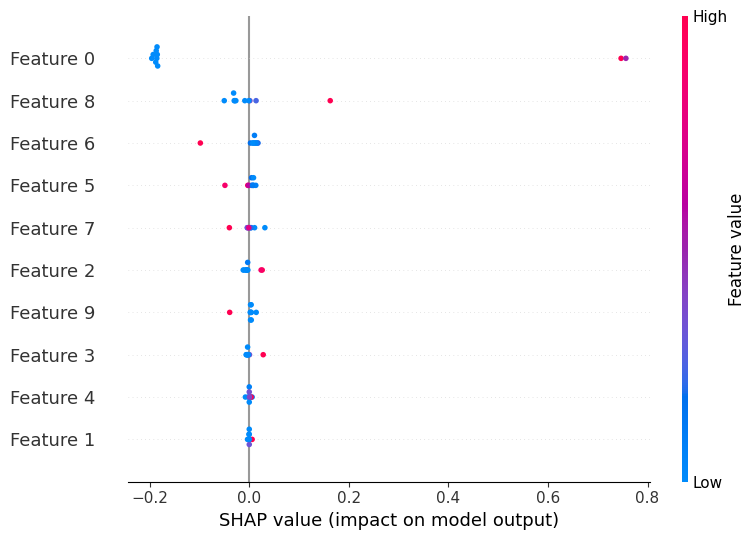

In [99]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import optuna
import shap
import matplotlib.pyplot as plt

# Set the random seed
RANDOM_SEED = 170827
np.random.seed(RANDOM_SEED)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Objective function for Optuna
def objective(trial):
    temp_acc = []

    # Suggest hyperparameters
    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = [trial.suggest_int(f"Num Hidden_{i}", 1, 500) for i in range(n_layers)]
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1, log=True)
    max_iter = trial.suggest_int("max_iter", 50, 500)
    tol = trial.suggest_float("tol", 1e-5, 1e-3, log=True)

    # Cross-validation loop
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_temp, x_val_temp = x_train[train_index], x_train[test_index]
        y_train_temp, y_val_temp = y_train[train_index], y_train[test_index]

        model = MLPClassifier(
            hidden_layer_sizes=layers,
            alpha=alpha,
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            max_iter=max_iter,
            tol=tol,
            early_stopping=True,
            validation_fraction=0.3,
            random_state=RANDOM_SEED
        )

        # Train the Model
        model.fit(x_train_temp, y_train_temp.ravel())

        # Predict and calculate accuracy for this fold
        y_pred = model.predict(x_val_temp)
        acc = metrics.accuracy_score(y_val_temp, y_pred)
        temp_acc.append(acc)

    # Calculate mean accuracy across folds
    mean_acc = np.mean(temp_acc)
    print(f"Trial {trial.number}: Accuracy = {mean_acc}")
    return mean_acc

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, timeout=3600)

# Best parameters
print("Best parameters:")
print(study.best_params)

# Subset the first 10 features directly
x_train_top10 = x_train[:, :10]
x_test_top10 = x_test[:, :10]  # Apply the same transformation to the test set

# Retrain the best model on the first 10 features
n_layers = study.best_params["n_layers"]
layers = [study.best_params[f"Num Hidden_{i}"] for i in range(n_layers)]

best_model = MLPClassifier(
    hidden_layer_sizes=layers,
    alpha=study.best_params["alpha"],
    learning_rate=study.best_params["learning_rate"],
    learning_rate_init=study.best_params["learning_rate_init"],
    max_iter=study.best_params["max_iter"],
    tol=study.best_params["tol"],
    early_stopping=True,
    validation_fraction=0.3,
    random_state=RANDOM_SEED
)

# Train the model on the first 10 features
best_model.fit(x_train_top10, y_train.ravel())

# Compute SHAP values for the first 10 features
print("Computing SHAP values...")
explainer = shap.KernelExplainer(best_model.predict, x_train_top10[:10])
shap_values = explainer.shap_values(x_train_top10[:10])

import matplotlib.pyplot as plt


print("Generating SHAP summary plot...")
plt.figure()  # Create a new figure
shap.summary_plot(
    shap_values, 
    x_train_top10[:10], 
    feature_names=[f"Feature {i}" for i in range(10)],
    show=True  
)

# Save the SHAP plot in multiple formats
output_path = "/home/dell/NSCLC_code/18_11_24/"
plt.savefig(f"{output_path}shap_summary_plot.png", format="png", dpi=1200)
plt.savefig(f"{output_path}shap_summary_plot.pdf", format="pdf")
plt.savefig(f"{output_path}shap_summary_plot.svg", format="svg")
plt.close()  # Close the plot after saving to free memory




In [100]:
plt.figure()  # Create a new figure
shap.summary_plot(
    shap_values, 
    x_train_top10[:10], 
    feature_names=[f"Feature {i}" for i in range(10)],
    show=False
)

# Save the SHAP plot in multiple formats
output_path = "/home/dell/NSCLC_code/18_11_24/"
plt.savefig(f"{output_path}shap_summary_plot.png", format="png", dpi=1200)
plt.savefig(f"{output_path}shap_summary_plot.pdf", format="pdf")
plt.savefig(f"{output_path}shap_summary_plot.svg", format="svg")
plt.close()  # Close the plot after saving to free memory



# 7. **Plots**

## 7.1 AUROC

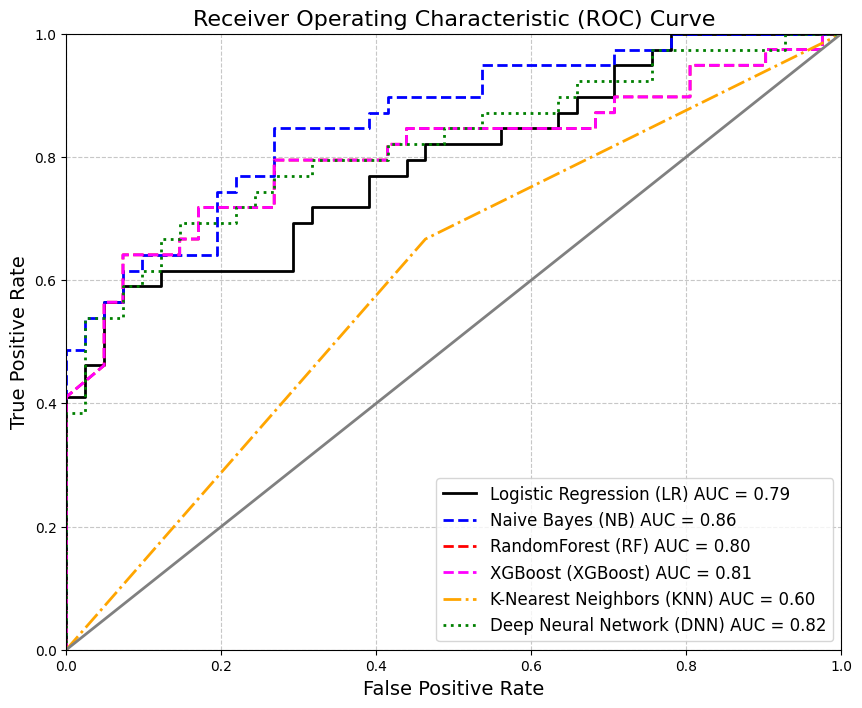

In [101]:
# LR
#ROC Curve
probs_lr = model_lr_1.predict_proba(x_test)
preds_lr = probs_lr[:,1]

fpr_lr, tpr_lr, threshold_lr = metrics.roc_curve(y_test, preds_lr)
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)


# NB
probs_nb = model_nb_1.predict_proba(x_test)
preds_nb = probs_nb[:,1]

fpr_nb, tpr_nb, threshold_nb = metrics.roc_curve(y_test, preds_nb)
roc_auc_nb = metrics.auc(fpr_nb, tpr_nb)


# RF
probs_rfc = model_rfc_1.predict_proba(x_test)
preds_rfc = probs_rfc[:,1]

fpr_rfc, tpr_rfc, threshold_rfc = metrics.roc_curve(y_test, preds_rfc)
roc_auc_rfc = metrics.auc(fpr_rfc, tpr_rfc)



# XGBoost
probs_xgb = model_xgb_1.predict_proba(x_test)
preds_xgb = probs_xgb[:,1]

fpr_xgb, tpr_xgb, threshold_xgb = metrics.roc_curve(y_test, preds_xgb)
roc_auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

# KNN
probs_knn = model_knn_1.predict_proba(x_test)
preds_knn = probs_knn[:,1]

fpr_knn, tpr_knn, threshold_knn = metrics.roc_curve(y_test, preds_knn)
roc_auc_knn = metrics.auc(fpr_knn, tpr_knn)

# DNN
probs_dnn = model_nn_1.predict_proba(x_test)
preds_dnn = probs_dnn[:,1]


fpr_dnn, tpr_dnn, threshold_dnn = metrics.roc_curve(y_test, preds_dnn)
roc_auc_dnn = metrics.auc(fpr_dnn, tpr_dnn)

# Plotting the AU-ROC curves
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

# Plot ROC curves for each model
plt.plot(fpr_lr, tpr_lr, color='black', linestyle='-', linewidth=2, label=f'Logistic Regression (LR) AUC = {roc_auc_lr:.2f}')
plt.plot(fpr_nb, tpr_nb, color='blue', linestyle='--', linewidth=2, label=f'Naive Bayes (NB) AUC = {roc_auc_nb:.2f}')
plt.plot(fpr_xgb, tpr_xgb, color='red', linestyle='--', linewidth=2, label=f'RandomForest (RF) AUC = {roc_auc_rfc:.2f}')
plt.plot(fpr_xgb, tpr_xgb, color='magenta', linestyle='--', linewidth=2, label=f'XGBoost (XGBoost) AUC = {roc_auc_xgb:.2f}')
plt.plot(fpr_knn, tpr_knn, color='orange', linestyle='-.', linewidth=2, label=f'K-Nearest Neighbors (KNN) AUC = {roc_auc_knn:.2f}')
plt.plot(fpr_dnn, tpr_dnn, color='green', linestyle=':', linewidth=2, label=f'Deep Neural Network (DNN) AUC = {roc_auc_dnn:.2f}')


# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linewidth=2, color='gray')

# Add labels and legend
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


## 7.2 CONFUSION MATRIX 

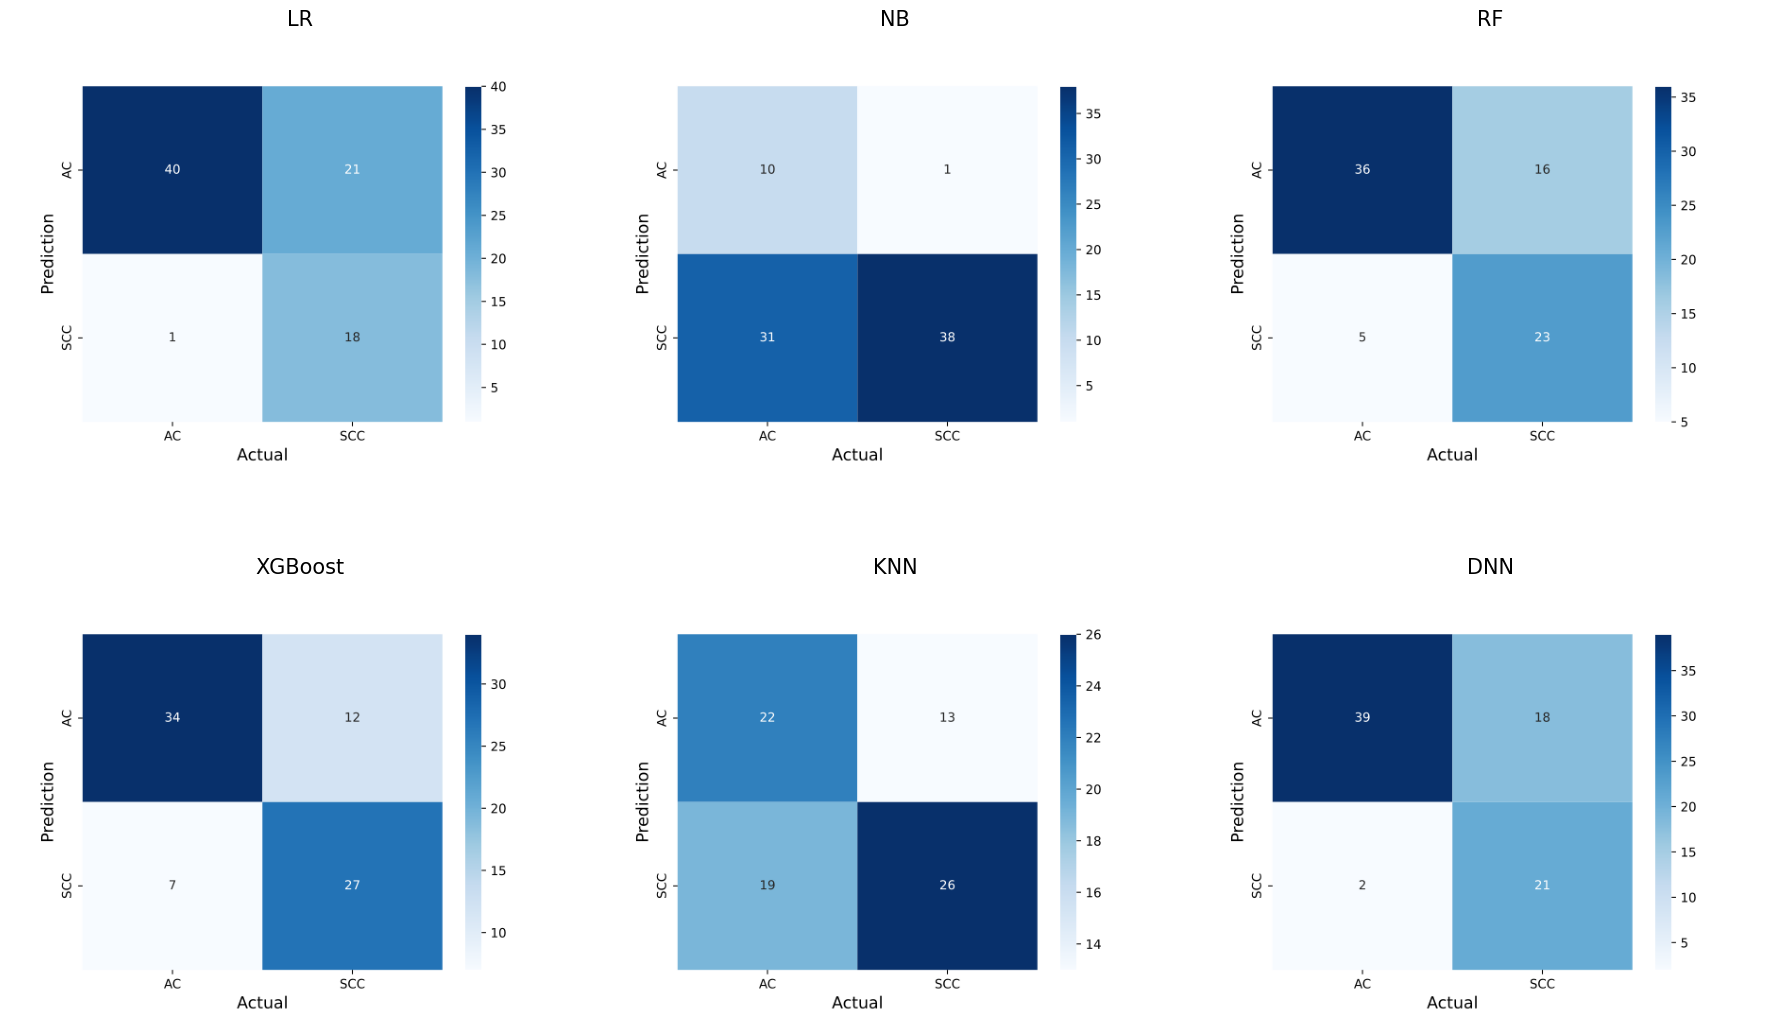

In [102]:
import matplotlib.pyplot as plt
from PIL import Image
import cairosvg
import io

# Function to convert SVG to PNG and return as an Image object
def svg_to_image(filename):
    png_data = cairosvg.svg2png(url=filename)
    img = Image.open(io.BytesIO(png_data))
    return img

# Load the SVG images and convert them to PNG
lr_img = svg_to_image('LR1_confusion_matrix.svg')
nb_img = svg_to_image('NB1_confusion_matrix.svg')
rf_img = svg_to_image('RF1_confusion_matrix.svg')
xgb_img = svg_to_image('XGB1_confusion_matrix.svg')
knn_img = svg_to_image('KNN1_confusion_matrix.svg')
dnn_img = svg_to_image('DNN1_confusion_matrix.svg')

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Function to add an image to an axis
def add_image(ax, img, title):
    ax.imshow(img)
    ax.axis('off')  # Hide the axis
    ax.set_title(title, fontsize=15)

# Add the images to the subplots
add_image(axes[0, 0], lr_img, 'LR')
add_image(axes[0, 1], nb_img, 'NB')
add_image(axes[0, 2], rf_img, 'RF')
add_image(axes[1, 0], xgb_img, 'XGBoost')
add_image(axes[1, 1], knn_img, 'KNN')
add_image(axes[1, 2], dnn_img, 'DNN')

# Adjust layout
plt.tight_layout()

# Save the figure in different formats
plt.savefig('merged_confusion_matrices.svg')
plt.savefig('merged_confusion_matrices.png')
plt.savefig('merged_confusion_matrices.pdf')

# Show the figure
plt.show()


## 7.3 Plotting Result Biomarker

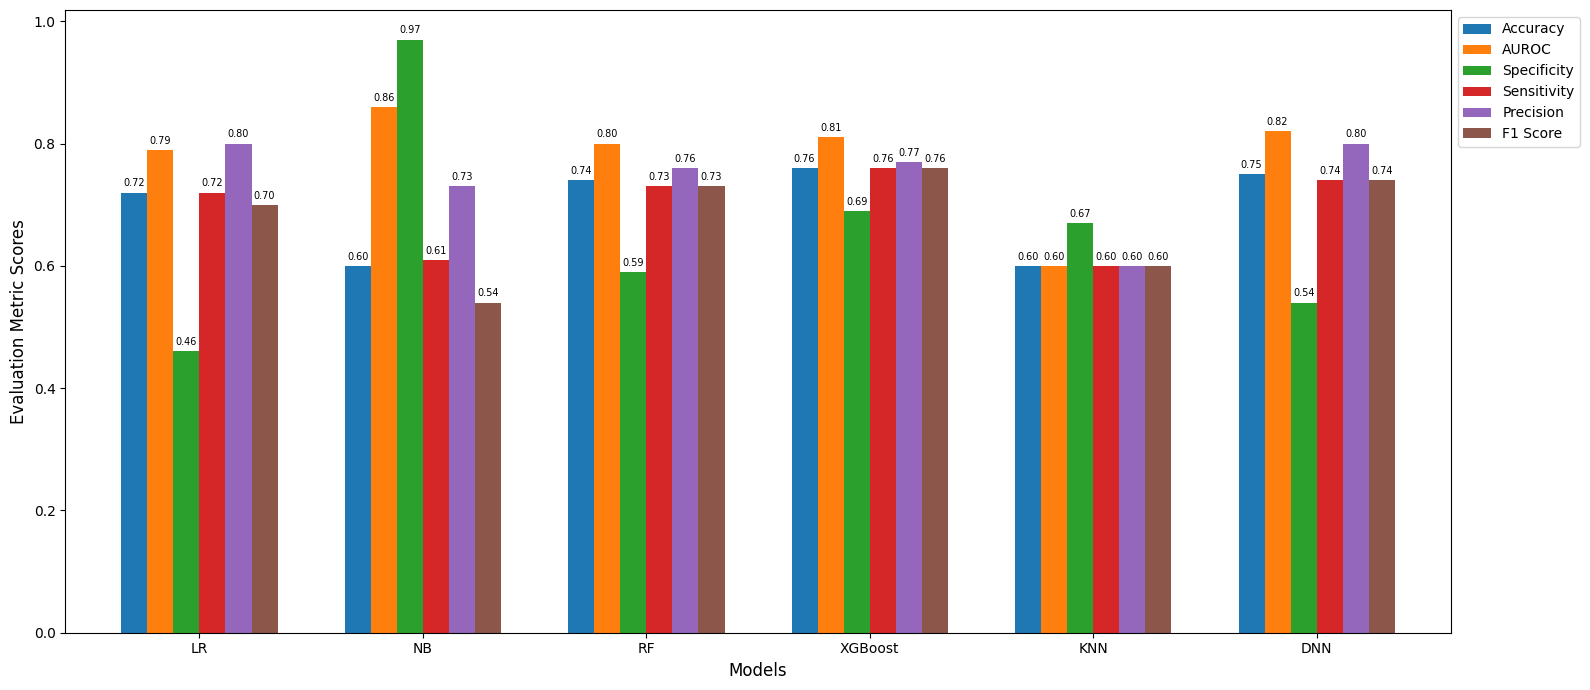

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Initialization
results_data = pd.DataFrame()
Model_names = ["LR", "NB", "RF", "XGBoost", "KNN", "DNN"]
true_neg = [18, 38, 23, 27, 26, 21]
false_neg = [1, 31, 5, 7, 19, 2]
false_pos = [21, 1, 16, 12, 13, 18]
true_pos = [40, 10, 36, 34, 22, 39]
auroc_1 = [0.79, 0.86, 0.80, 0.81, 0.60, 0.82]

# Populate DataFrame
results_data["Model_names"] = Model_names
results_data["true_neg"] = true_neg
results_data["false_neg"] = false_neg
results_data["false_pos"] = false_pos
results_data["true_pos"] = true_pos

# Function to Calculate Metrics
def find_macro_avg_metrics(data):
    data_np = data[["true_neg", "false_neg", "false_pos", "true_pos"]].to_numpy()
    A, P, SP, SN, F1 = [], [], [], [], []

    for i in range(len(data_np)):
        tn, fn, fp, tp = data_np[i]
        total = tn + fn + fp + tp

        # Class 0 (Negative Class) Metrics
        precision_0 = tn / (tn + fn) if (tn + fn) > 0 else 0
        recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0) if (precision_0 + recall_0) > 0 else 0

        # Class 1 (Positive Class) Metrics
        precision_1 = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1) if (precision_1 + recall_1) > 0 else 0

        # Macro Averages
        acc = (tp + tn) / total
        precision_macro = (precision_0 + precision_1) / 2
        specificity_macro = recall_0  # Specificity is recall of the negative class
        recall_macro = (recall_0 + recall_1) / 2  # Sensitivity/Recall is averaged over both classes
        f1_macro = (f1_0 + f1_1) / 2


        A.append(acc)
        P.append(precision_macro)
        SP.append(specificity_macro)
        SN.append(recall_macro)
        F1.append(f1_macro)

    # Add Metrics to DataFrame
    new_data = data.copy()
    new_data["Accuracy"] = np.round(A, 2)
    new_data["Precision"] = np.round(P, 2)
    new_data["Specificity"] = np.round(SP, 2)
    new_data["Sensitivity"] = np.round(SN, 2)  # Add Sensitivity explicitly
    new_data["F1 Score"] = np.round(F1, 2)
    return new_data

# Calculate Metrics and Add AUC
result_data_2 = find_macro_avg_metrics(results_data)
result_data_2["AUROC"] = auroc_1

# Plot grouped bar chart
ax = result_data_2[["Model_names", "Accuracy", "AUROC", "Specificity", "Sensitivity", "Precision", "F1 Score"]].plot(
    x='Model_names', kind='bar', stacked=False, figsize=(16, 7), rot=0, width=0.7,
    color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
)

# Add labels on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3, fontsize=7)

# Customize legend and save the figure
plt.xlabel("Models", fontsize=12)
plt.ylabel("Evaluation Metric Scores", fontsize=12)
plt.legend(["Accuracy", "AUROC", "Specificity", "Sensitivity", "Precision", "F1 Score"], loc="upper left", 
           bbox_to_anchor=(1, 1), fontsize=10)
plt.tight_layout()
plt.savefig("comparison_model_macro_avg_with_sensitivity.png", bbox_inches='tight')
plt.savefig("comparison_model_macro_avg_with_sensitivity.pdf", bbox_inches='tight')
plt.show()


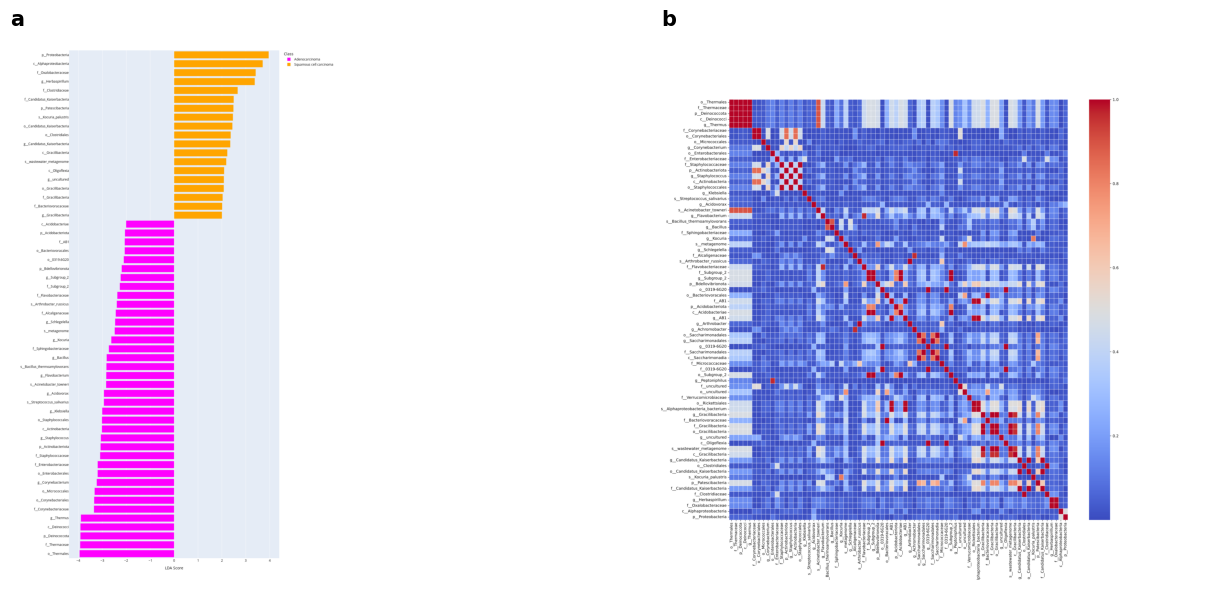

In [109]:
import matplotlib.pyplot as plt
from PIL import Image
import cairosvg
import io

# Function to convert SVG to PNG and return as an Image object
def svg_to_image(filename):
    png_data = cairosvg.svg2png(url=filename)
    img = Image.open(io.BytesIO(png_data))
    return img

# Load the SVG images and convert them to PNG
lefse_img = svg_to_image('lefse_otu_all.svg')
heatmap_img = svg_to_image('heatmap_correlation.svg')
#confusion_img = svg_to_image('merged_confusion_matrices.svg')

# Create a figure with a 1x1 grid of subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Function to add an image to an axis
def add_image(ax, img, title):
    ax.imshow(img)
    ax.axis('off')  # Hide the axis
    ax.set_title(title, loc='left', fontsize=15, weight='bold')

# Add the images to the subplots
add_image(axes[0], lefse_img, 'a')
add_image(axes[1], heatmap_img, 'b')
#add_image(axes[1,0], confusion_img, 'c')

# Adjust layout
plt.tight_layout()

# Save the figure in different formats
#plt.savefig('combined_figure.svg')
#plt.savefig('combined_figure.png')
#plt.savefig('combined_figure.pdf')

# Show the figure
plt.show()


# 8. **Validation**

## 8.1 Dataset I (97 samples)

### 8.1.1 Data Preprocessing

In [110]:
## Loading all the datasets
feature_table = pd.read_csv("/home/dell/NSCLC_code/16_aug_24/Data/97_samples/feature-table.tsv", sep='\t')
label_data = pd.read_excel("/home/dell/NSCLC_code/16_aug_24/Data/97_samples/label_data.xlsx")
meta_data = pd.read_csv("/home/dell/NSCLC_code/16_aug_24/Data/97_samples/sample_metadata.tsv", sep='\t')

# OTU_ID, PatientID1, PatientID2 ..., Taxonomy

feature_table_copy = copy.deepcopy(feature_table)

######### LABEL DATA #########
# PatientID: Treatment
label_data_np=np.array(label_data)

for i in range(len(label_data_np)):
    if (label_data_np[i][1] =='squamous carcinoma'):
        label_data_np[i][1] = 'Squamous'

map_id_to_label = {}
for i in range(len(label_data_np)):
    map_id_to_label[label_data_np[i][0]] = label_data_np[i][1]

print(f'Unique labels: {np.unique(label_data_np[:,1])}')

map_otu_to_taxo = {}
for i,otu in enumerate(list(feature_table["otu_id"])):
    map_otu_to_taxo[f'OTU_{i}'] = feature_table.loc[i, 'taxonomy']

######### Cleaning the Data #########
feature_table_copy = feature_table_copy.drop(columns=["otu_id","taxonomy"])
feature_table_copy = feature_table_copy.T
feature_table_copy.columns = list(map_otu_to_taxo.keys())

# Creating the Treatment Column
feature_table_copy["label"] = [map_id_to_label[i] for i in feature_table_copy.index]
feature_table_copy

# Removing the rows with NaN values
feature_table_copy = feature_table_copy.dropna()

# Removing the rows with "lung_normal_tissue" label
# feature_table_copy = feature_table_copy[feature_table_copy["label"] != "lung normal tissue"]
# feature_table_copy = feature_table_copy[feature_table_copy["label"] != "lung normal tissue "]

feature_table_copy = feature_table_copy[feature_table_copy["label"] != "Adenosquamous cell carcinoma"]

table_data = copy.deepcopy(feature_table_copy)

table_data["label"] = le.transform(table_data["label"])
print(f'Class Labels: {le.classes_}')

numpy_data = table_data.drop(columns=["label"]).to_numpy()
table_data

Unique labels: ['Adenocarcinoma' 'Adenosquamous cell carcinoma' 'Squamous']
Class Labels: ['Adenocarcinoma' 'Squamous']


,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,OTU_1639,OTU_1640,OTU_1641,OTU_1642,OTU_1643,OTU_1644,OTU_1645,OTU_1646,OTU_1647,label
SRR3996747,107,104,93,89,84,61,57,35,27,26,...,0,0,0,0,0,0,0,0,0,0
SRR3996737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3996701,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3996712,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3996702,157,122,147,171,140,186,162,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3996773,64,45,59,48,64,58,42,0,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3996750,127,126,130,140,140,111,89,3,4,11,...,0,0,0,0,0,0,0,0,0,1
SRR3996706,125,113,114,124,152,110,157,8,15,7,...,0,0,0,0,0,0,0,0,0,0
SRR3996756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 8.1.1.1 Taxa Conversions

In [111]:
## 2.2 Taxonomy wise Data Division
taxonomy_arr = []

for i in range(len(map_otu_to_taxo)):
    taxonomy_arr.append(map_otu_to_taxo[f'OTU_{i}'])

print(f'Number of unique taxonomy: {len(np.unique(taxonomy_arr))}')
print(f'Lenght of the taxonomy array: {len(taxonomy_arr)}')
### 2.3.1 Phyllum 
phyllum_labels=[]
count_no_phyllum=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>1):
    if (temp[1] not in phyllum_labels):
      phyllum_labels.append(temp[1])

# Counting the number of taxa with only dynasty labels
for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==1):
    count_no_phyllum=count_no_phyllum+1

print("Number of Taxa without the phyllum labels:-",count_no_phyllum)

print("No. of distinct phyllum are:-",len(phyllum_labels))
print(phyllum_labels)

# Processing the data to get the phyllum data
temp_dict={}
for i in range(len(phyllum_labels)):
  temp_dict[phyllum_labels[i]]=0

temps_arr=[]


for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>1):
      new_dict[temp[1]]=new_dict[temp[1]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

phylum_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

# phylum_data.to_csv("phylum_data.csv")
phylum_data
### 2.3.2 Class
class_labels=[]
count_no_class=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>2):
    if (temp[2] not in class_labels):
      class_labels.append(temp[2])

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==2):
    count_no_class=count_no_class+1

print("Number of Taxa without the class labels:-",count_no_class)

print("No. of distinct class are:-",len(class_labels))
print(class_labels)


# Processing the data to get the class data
temp_dict={}
for i in range(len(class_labels)):
  temp_dict[class_labels[i]]=0

temp_dict

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>2):
      new_dict[temp[2]]=new_dict[temp[2]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

class_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

# class_data.to_csv("class_data.csv")
class_data
### 2.3.3 Order
order_labels=[]
count_no_order=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>3):
    if (temp[3] not in order_labels):
      order_labels.append(temp[3])

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)==3):
    count_no_order=count_no_order+1

print("Number of Taxa without the order labels:-",count_no_order)

print("No. of distinct order are:-",len(order_labels))
print(order_labels)

temp_dict={}
for i in range(len(order_labels)):
  temp_dict[order_labels[i]]=0

temp_dict

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>3):
      new_dict[temp[3]]=new_dict[temp[3]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

order_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

# order_data.to_csv("order_data.csv")
order_data
### 2.3.4 Family
family_labels=[]
count_no_family=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>4):
    if (temp[4] not in family_labels):
      family_labels.append(temp[4])

for i in range(len(taxonomy_arr)):
    temp=taxonomy_arr[i]
    temp=temp.split(";")
    if (len(temp)==4):
        count_no_family=count_no_family+1

print("Number of Taxa without the family labels:-",count_no_family)

print("No. of distinct family are:-",len(family_labels))
print(family_labels)

temp_dict={}
for i in range(len(family_labels)):
  temp_dict[family_labels[i]]=0


temps_arr=[]
for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>4):
      new_dict[temp[4]]=new_dict[temp[4]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

family_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

# family_data.to_csv("family_data.csv")
family_data

### 2.3.5 Genus
genus_labels=[] 
count_no_genus=0

for i in range(len(taxonomy_arr)):
  temp=taxonomy_arr[i]
  temp=temp.split(";")
  if (len(temp)>5):
    if (temp[5] not in genus_labels):
      genus_labels.append(temp[5])

for i in range(len(taxonomy_arr)):
    temp=taxonomy_arr[i]
    temp=temp.split(";")
    if (len(temp)==5):
        count_no_genus=count_no_genus+1

print("Number of Taxa without the genus labels:-",count_no_genus)

print("No. of distinct genus are:-",len(genus_labels))
print(genus_labels)

temp_dict={}
for i in range(len(genus_labels)):
  temp_dict[genus_labels[i]]=0

temps_arr=[]

for i in range(len(numpy_data)):

  temp_arr=numpy_data[i,:].ravel()
  new_dict=copy.deepcopy(temp_dict)

  
  for j in range(len(temp_arr)):
    temp=taxonomy_arr[j]
    temp=temp.split(";")
    if (len(temp)>5):
      new_dict[temp[5]]=new_dict[temp[5]]+temp_arr[j]

  temps_arr.append(list(new_dict.values()))

temps_arr=np.array(temps_arr)

temp_columns=list(temp_dict.keys())

genus_data=pd.DataFrame(temps_arr,columns=np.array(temp_columns),index=np.array(table_data.index))

# genus_data.to_csv("genus_data.csv")
genus_data
### 2.3.6 Combining all the data
phylum_data_np=np.array(phylum_data)
class_data_np=np.array(class_data)
order_data_np=np.array(order_data)
family_data_np=np.array(family_data)
genus_data_np=np.array(genus_data)

temp_data=np.c_[phylum_data_np,class_data_np,order_data_np,family_data_np,genus_data_np]

print(np.shape(temp_data))

comp_data=pd.DataFrame(temp_data,index=phylum_data.index,columns=list(phylum_data.columns)+list(class_data.columns)+list(order_data.columns)+list(family_data.columns)+list(genus_data.columns))
# comp_data["label"]=stan_data["label"]

comp_data["treatment"]=table_data['label']
# comp_data.to_csv("comp_data.csv")
comp_data

Number of unique taxonomy: 248
Lenght of the taxonomy array: 1648
Number of Taxa without the phyllum labels:- 0
No. of distinct phyllum are:- 16
[' p__Deinococcota', ' p__Proteobacteria', ' p__SAR324_clade(Marine_group_B)', ' p__Firmicutes', ' p__Bdellovibrionota', ' p__Bacteroidota', ' p__Actinobacteriota', ' p__Verrucomicrobiota', ' p__Patescibacteria', ' p__Cyanobacteria', ' p__Myxococcota', ' p__Fusobacteriota', ' p__Acidobacteriota', ' p__Campilobacterota', ' p__Planctomycetota', ' p__Chloroflexi']
Number of Taxa without the class labels:- 0
No. of distinct class are:- 31
[' c__Deinococci', ' c__Gammaproteobacteria', ' c__Alphaproteobacteria', ' c__SAR324_clade(Marine_group_B)', ' c__Bacilli', ' c__Bdellovibrionia', ' c__Bacteroidia', ' c__Actinobacteria', ' c__Clostridia', ' c__Chlamydiae', ' c__Parcubacteria', ' c__Gracilibacteria', ' c__Saccharimonadia', ' c__Cyanobacteriia', ' c__Negativicutes', ' c__Polyangia', ' c__Fusobacteriia', ' c__ABY1', ' c__Vampirivibrionia', ' c__Ign

,p__Deinococcota,p__Proteobacteria,p__SAR324_clade(Marine_group_B),p__Firmicutes,p__Bdellovibrionota,p__Bacteroidota,p__Actinobacteriota,p__Verrucomicrobiota,p__Patescibacteria,p__Cyanobacteria,...,g__Selenomonas,g__Cellulomonas,g__Azospirillum,g__Rickettsiella,g__Sedimentibacter,g__Leuconostoc,g__Absconditabacteriales_(SR1),g__Aquicella,g__Candidatus_Magasanikbacteria,treatment
SRR3996747,595,502,24,28,18,17,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR3996737,0,265,0,20,0,172,10,4,0,0,...,0,0,0,0,0,0,0,0,0,1
SRR3996701,0,762,0,143,0,158,0,0,36,0,...,0,0,0,0,0,0,0,0,0,0
SRR3996712,0,243,0,89,0,37,54,0,10,0,...,0,0,0,0,0,0,0,0,0,1
SRR3996702,1085,573,0,168,0,351,27,0,0,136,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3996773,380,99,0,34,2,83,0,0,63,4,...,0,0,0,0,0,0,0,0,0,1
SRR3996750,863,571,0,7,19,42,28,0,44,0,...,0,0,0,0,0,0,0,86,0,1
SRR3996706,895,292,0,24,32,58,53,0,67,0,...,0,0,0,0,0,0,0,0,0,0
SRR3996756,0,227,0,0,0,0,19,0,0,14,...,0,0,0,0,0,0,0,0,0,0


#### 8.1.1.2 choosing Features

In [112]:
if meta_data is not None:

    meta_data = meta_data[['Sample-id', 'env_material', 'host_sex', 'smoker', 'age']]

    meta_data.dropna(inplace=True)

    meta_data["env_material"]=le1.transform(meta_data["env_material"])
    meta_data["host_sex"]=le2.transform(meta_data["host_sex"])

    mapping = {
    'never': 'never smoker',
    'quit <6 months': 'smoker quit for less than 6 months',
    'quit >6 months': 'smoker quit for at least 6 months'
    }

    # Replace values using the mapping dictionary
    meta_data['smoker'] = meta_data['smoker'].map(mapping)
    meta_data["smoker"]=le3.transform(meta_data["smoker"])

    print(f'Unique env_material: {le1.classes_}')
    print(f'Unique host_sex: {le2.classes_}')
    print(f'Unique smoker: {le3.classes_}')

    meta_data_np = np.array(meta_data)

    sample_id_to_meta = {}
    for i in range(len(meta_data_np)):
        sample_id_to_meta[meta_data_np[i, 0]] = meta_data_np[i, 1:]


    # Combining the selected data with the metadata
    # Converting an dictionary to a dataframe
    meta_data = pd.DataFrame.from_dict(sample_id_to_meta, orient='index', columns=['env_material', 'host_sex', 'smoker', 'age'])

    complete_data = pd.merge(comp_data, meta_data, left_index=True, right_index=True)

    complete_data

else:
    complete_data = selected_data

# Adding the labels
temp_labels = comp_data['treatment']

complete_data = pd.merge(complete_data, temp_labels, left_index=True, right_index=True)

complete_data



Unique env_material: ['lung non-malignant tissue' 'lung tumor tissue']
Unique host_sex: ['female' 'male']
Unique smoker: ['never smoker' 'smoker quit for at least 6 months'
 'smoker quit for less than 6 months']


,p__Deinococcota,p__Proteobacteria,p__SAR324_clade(Marine_group_B),p__Firmicutes,p__Bdellovibrionota,p__Bacteroidota,p__Actinobacteriota,p__Verrucomicrobiota,p__Patescibacteria,p__Cyanobacteria,...,g__Leuconostoc,g__Absconditabacteriales_(SR1),g__Aquicella,g__Candidatus_Magasanikbacteria,treatment_x,env_material,host_sex,smoker,age,treatment_y
SRR3996747,595,502,24,28,18,17,5,0,0,0,...,0,0,0,0,0,0,0,1,66.97604,0
SRR3996737,0,265,0,20,0,172,10,4,0,0,...,0,0,0,0,1,1,1,2,62.99247,1
SRR3996701,0,762,0,143,0,158,0,0,36,0,...,0,0,0,0,0,1,0,0,70.99247,0
SRR3996712,0,243,0,89,0,37,54,0,10,0,...,0,0,0,0,1,1,1,2,60.53936,1
SRR3996702,1085,573,0,168,0,351,27,0,0,136,...,0,0,0,0,0,1,0,0,79.31006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3996773,380,99,0,34,2,83,0,0,63,4,...,0,0,0,0,1,0,1,1,74.17385,1
SRR3996750,863,571,0,7,19,42,28,0,44,0,...,0,0,86,0,1,0,1,1,73.68104,1
SRR3996706,895,292,0,24,32,58,53,0,67,0,...,0,0,0,0,0,1,0,0,66.92950,0
SRR3996756,0,227,0,0,0,0,19,0,0,14,...,0,0,0,0,0,0,1,2,51.25257,0


In [113]:
new_features = list(result_data.columns)
not_in_list = []

for i in range(len(new_features)):    
    if (new_features[i] not in list(complete_data.columns)):
        not_in_list.append(new_features[i])
    


print(new_features)
print(not_in_list)

# Adding the missing features
for feature in not_in_list:
    complete_data[feature] = 0

selected_data = complete_data[new_features[:-1]]
selected_data['treatment'] = complete_data['treatment_y']
selected_data


[' o__Thermales', ' f__Corynebacteriaceae', ' o__Micrococcales', ' g__Corynebacterium', ' o__Enterobacterales', ' p__Proteobacteria', ' c__Alphaproteobacteria', ' g__Herbaspirillum', ' p__Patescibacteria', ' s__Kocuria_palustris', 'env_material', 'host_sex', 'smoker', 'age', 'label']
[' s__Kocuria_palustris', 'label']


/tmp/ipykernel_281749/4032811831.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,o__Thermales,f__Corynebacteriaceae,o__Micrococcales,g__Corynebacterium,o__Enterobacterales,p__Proteobacteria,c__Alphaproteobacteria,g__Herbaspirillum,p__Patescibacteria,s__Kocuria_palustris,env_material,host_sex,smoker,age,treatment
SRR3996747,595,0,5,0,44,502,126,21,0,0,0,0,1,66.97604,0
SRR3996737,0,4,6,0,0,265,18,10,0,0,1,1,2,62.99247,1
SRR3996701,0,0,0,0,55,762,283,76,36,0,1,0,0,70.99247,0
SRR3996712,0,2,36,0,0,243,0,19,10,0,1,1,2,60.53936,1
SRR3996702,1085,0,27,0,0,573,104,36,0,0,1,0,0,79.31006,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR3996773,380,0,0,0,0,99,20,19,63,0,0,1,1,74.17385,1
SRR3996750,863,10,18,0,24,571,179,0,44,0,0,1,1,73.68104,1
SRR3996706,895,37,13,0,0,292,124,0,67,0,1,0,0,66.92950,0
SRR3996756,0,16,0,0,7,227,74,8,0,0,0,1,2,51.25257,0


In [114]:
x_data_pd = selected_data.drop(columns=['treatment'])

x_data_pd_stan = pd.DataFrame(scaler.transform(x_data_pd),columns=x_data_pd.columns,index=x_data_pd.index)

y_test = np.array(selected_data['treatment'])

if SFFS_true:
    x_test = np.array(x_data_pd_stan[chosen_features])

else:
    x_test = np.array(x_data_pd_stan)

### 8.1.2 Model Building

#### 8.1.2.1 Logistic Regression

##### 8.1.2.1.1 Degree = 1

Training Accuracy is:- 0.726775956284153
Classification Accuracy is:- 0.5555555555555556
                precision    recall  f1-score   support

Adenocarcinoma       0.52      0.64      0.57        42
      Squamous       0.61      0.48      0.53        48

      accuracy                           0.56        90
     macro avg       0.56      0.56      0.55        90
  weighted avg       0.57      0.56      0.55        90



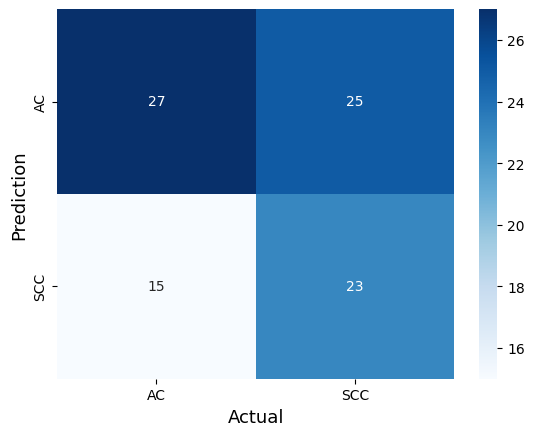

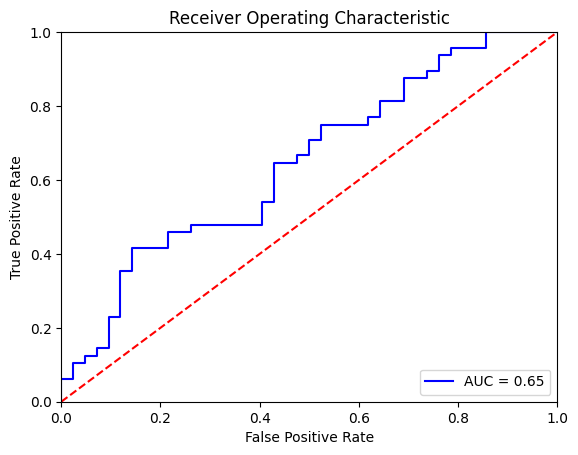

In [115]:

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 170821
np.random.seed(RANDOM_SEED)


model_lr = LogisticRegression(random_state=0).fit(x_train,y_train)
y_pred_lr=model_lr.predict(x_test)

print("Training Accuracy is:-",model_lr.score(x_train,y_train))
print("Classification Accuracy is:-",model_lr.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_lr,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("LR1_test_data_confusion_matrix.svg", format='svg')


plt.show()

#ROC Curve
probs_lr_test = model_lr.predict_proba(x_test)
preds_lr_test = probs_lr_test[:,1]

fpr_lr_test, tpr_lr_test, threshold_lr_test = metrics.roc_curve(y_test, preds_lr_test)
roc_auc_lr_test = metrics.auc(fpr_lr_test, tpr_lr_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr_test, tpr_lr_test, 'b', label = 'AUC = %0.2f' % roc_auc_lr_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### 8.1.2.2 Gaussian Naive Bayes

##### 8.1.2.2.1 Degree = 1

Training Accuracy is:- 0.546448087431694
Classification Accuracy is:- 0.5444444444444444
                precision    recall  f1-score   support

Adenocarcinoma       0.55      0.14      0.23        42
      Squamous       0.54      0.90      0.68        48

      accuracy                           0.54        90
     macro avg       0.54      0.52      0.45        90
  weighted avg       0.54      0.54      0.47        90



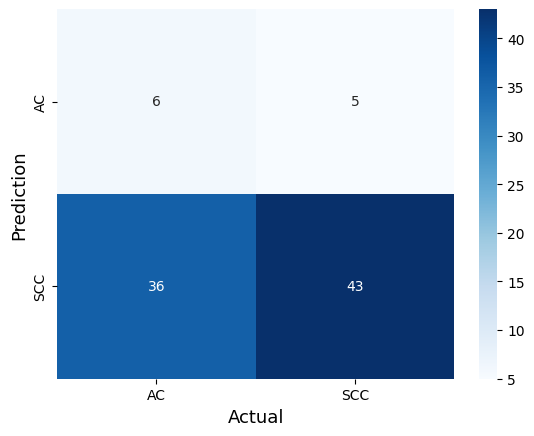

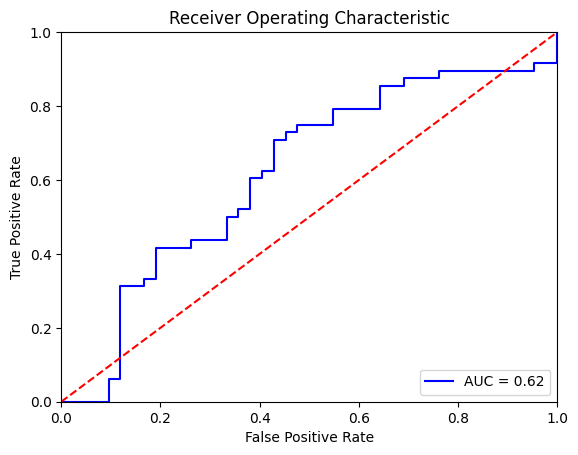

In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708213
np.random.seed(RANDOM_SEED)


model_nb = GaussianNB().fit(x_train,y_train)
y_pred_nb=model_nb.predict(x_test)

print("Training Accuracy is:-",model_nb.score(x_train,y_train))
print("Classification Accuracy is:-",model_nb.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_nb, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_nb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("NB1_test_data_confusion_matrix.svg", format='svg')

plt.show()

#ROC Curve
probs_nb_test = model_nb.predict_proba(x_test)
preds_nb_test = probs_nb_test[:,1]

fpr_nb_test, tpr_nb_test, threshold_nb_test = metrics.roc_curve(y_test, preds_nb_test)
roc_auc_nb_test = metrics.auc(fpr_nb_test, tpr_nb_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_nb_test, tpr_nb_test, 'b', label = 'AUC = %0.2f' % roc_auc_nb_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 8.1.2.4 Random Forest Classifier

##### 8.1.2.4.1 Degree = 1

[I 2024-12-07 00:45:31,498] A new study created in memory with name: no-name-a4c0f037-844d-4878-9bd5-607e85ea227b
[I 2024-12-07 00:45:32,089] Trial 0 finished with value: 0.5633633633633635 and parameters: {'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 42, 'max_leaf_nodes': 34, 'n_estimators': 73}. Best is trial 0 with value: 0.5633633633633635.
[I 2024-12-07 00:45:32,416] Trial 1 finished with value: 0.5735735735735735 and parameters: {'max_depth': 9, 'min_samples_split': 18, 'min_samples_leaf': 25, 'max_leaf_nodes': 24, 'n_estimators': 51}. Best is trial 1 with value: 0.5735735735735735.
[I 2024-12-07 00:45:32,834] Trial 2 finished with value: 0.6448948948948948 and parameters: {'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_leaf_nodes': 78, 'n_estimators': 63}. Best is trial 2 with value: 0.6448948948948948.
[I 2024-12-07 00:45:32,994] Trial 3 finished with value: 0.6551051051051051 and parameters: {'max_depth': 7, 'min_samples_split': 21, 'min_sa

{'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_leaf_nodes': 81, 'n_estimators': 56}
Training Accuracy is:- 0.7814207650273224
Classification Accuracy is:- 0.5444444444444444
                precision    recall  f1-score   support

Adenocarcinoma       0.51      0.69      0.59        42
      Squamous       0.61      0.42      0.49        48

      accuracy                           0.54        90
     macro avg       0.56      0.55      0.54        90
  weighted avg       0.56      0.54      0.54        90



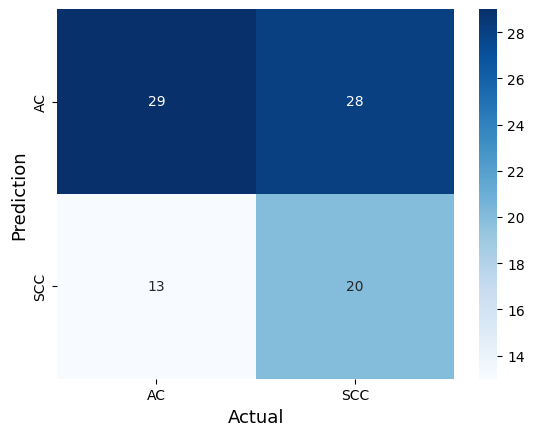

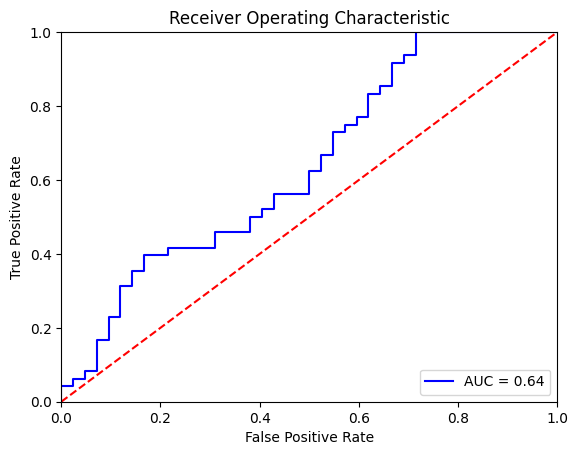

In [117]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708217
np.random.seed(RANDOM_SEED)


def objective(trial):

  temp_acc = []

  max_depth = trial.suggest_int("max_depth", 1, 10)

  min_samples_split = trial.suggest_int("min_samples_split",2,50)

  min_samples_leaf = trial.suggest_int("min_samples_leaf",1,50)

  max_leaf_nodes = trial.suggest_int("max_leaf_nodes",5,100)

  n_estimators = trial.suggest_int("n_estimators",10,100)

  #K-fold stratified Split
  for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    y_train_temp = y_train[train_index]
    x_train_temp = x_train[train_index]

    y_val_temp = y_train[test_index]
    x_val_temp = x_train[test_index]

    model = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes = max_leaf_nodes,n_estimators=n_estimators,random_state=42)

    #Training the Model
    model.fit(x_train_temp,y_train_temp.ravel())

    y_pred = model.predict(x_val_temp)

    v0 = metrics.accuracy_score(y_val_temp, y_pred)

    temp_acc.append(v0)

  return np.array(temp_acc).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

temp_dict = study.best_params

max_depth = temp_dict["max_depth"]

min_samples_split = temp_dict["min_samples_split"]

min_samples_leaf = temp_dict["min_samples_leaf"]

max_leaf_nodes = temp_dict["max_leaf_nodes"]

n_estimators = temp_dict["n_estimators"]

model_rfc = RandomForestClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_leaf_nodes = max_leaf_nodes,n_estimators=n_estimators,random_state=42).fit(x_train,y_train)
y_pred_rfc=model_rfc.predict(x_test)


print("Training Accuracy is:-",model_rfc.score(x_train,y_train))
print("Classification Accuracy is:-",model_rfc.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_rfc, target_names=target_names))

# Confusion Matrix
dat_lr=confusion_matrix(y_pred_rfc,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("RF1_test_data_confusion_matrix.svg", format='svg')
plt.show()

#ROC Curve
probs_rfc_test = model_rfc.predict_proba(x_test)
preds_rfc_test = probs_rfc_test[:,1]

fpr_rfc_test, tpr_rfc_test, threshold_rfc_test = metrics.roc_curve(y_test, preds_rfc_test)
roc_auc_rfc_test = metrics.auc(fpr_rfc_test, tpr_rfc_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rfc_test, tpr_rfc_test, 'b', label = 'AUC = %0.2f' % roc_auc_rfc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### 8.1.2.5 XGBoost Classifier

##### 8.1.2.5.1 Degree = 1

[I 2024-12-07 00:46:07,955] A new study created in memory with name: no-name-a02bebc2-01b9-49e5-8f9f-40d9d92a1dc8
[I 2024-12-07 00:46:08,434] Trial 0 finished with value: 0.6012012012012012 and parameters: {'max_depth': 2}. Best is trial 0 with value: 0.6012012012012012.
[I 2024-12-07 00:46:08,878] Trial 1 finished with value: 0.5900900900900901 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.6012012012012012.
[I 2024-12-07 00:46:09,289] Trial 2 finished with value: 0.5900900900900901 and parameters: {'max_depth': 8}. Best is trial 0 with value: 0.6012012012012012.
[I 2024-12-07 00:46:09,566] Trial 3 finished with value: 0.5798798798798799 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.6012012012012012.
[I 2024-12-07 00:46:09,892] Trial 4 finished with value: 0.5798798798798799 and parameters: {'max_depth': 3}. Best is trial 0 with value: 0.6012012012012012.
[I 2024-12-07 00:46:10,108] Trial 5 finished with value: 0.6387387387387389 and parameters: {'ma

{'max_depth': 1}
Training Accuracy is:- 0.8087431693989071
Classification Accuracy is:- 0.6444444444444445
                precision    recall  f1-score   support

Adenocarcinoma       0.60      0.71      0.65        42
      Squamous       0.70      0.58      0.64        48

      accuracy                           0.64        90
     macro avg       0.65      0.65      0.64        90
  weighted avg       0.65      0.64      0.64        90



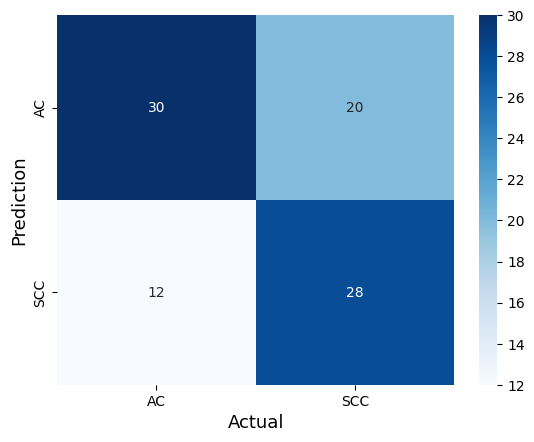

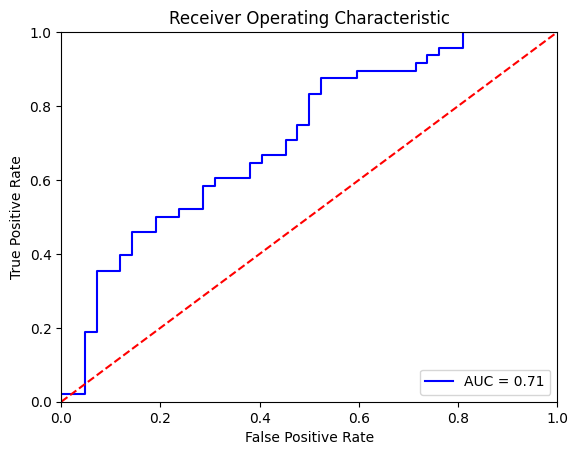

In [118]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

# Set the random seed

RANDOM_SEED = 1708219
np.random.seed(RANDOM_SEED)


def objective(trial):

  temp_acc = []

  max_depth = trial.suggest_int("max_depth", 1, 10)

  #K-fold stratified Split
  for i, (train_index, test_index) in enumerate(skf.split(x_train, y_train)):
    y_train_temp = y_train[train_index]
    x_train_temp = x_train[train_index]

    y_val_temp = y_train[test_index]
    x_val_temp = x_train[test_index]

    model = XGBClassifier(max_depth=max_depth,random_state=42)

    #Training the Model
    model.fit(x_train_temp,y_train_temp.ravel())

    y_pred = model.predict(x_val_temp)

    v0 = metrics.accuracy_score(y_val_temp, y_pred)
    temp_acc.append(v0)

  return np.array(temp_acc).mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print(study.best_params)

temp_dict = study.best_params

max_depth = temp_dict["max_depth"]

model_xgb = XGBClassifier(max_depth=max_depth,random_state=42).fit(x_train,y_train)
y_pred_xgb=model_xgb.predict(x_test)

print("Training Accuracy is:-",model_xgb.score(x_train,y_train))
print("Classification Accuracy is:-",model_xgb.score(x_test,y_test))

target_names = ['Adenocarcinoma','Squamous']
print(classification_report(y_test, y_pred_xgb, target_names=target_names))

dat_lr=confusion_matrix(y_pred_xgb,y_test)
sns.heatmap(dat_lr,annot=True,xticklabels=['AC','SCC'],
            yticklabels=['AC','SCC'],cmap='Blues')
#plt.title("Standardised Data")
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)

# Save the confusion matrix as an SVG file
plt.savefig("XGB1_test_data_confusion_matrix.svg", format='svg')


plt.show()

probs_xgb_test = model_xgb.predict_proba(x_test)
preds_xgb_test = probs_xgb_test[:,1]

fpr_xgb_test, tpr_xgb_test, threshold_xgb_test = metrics.roc_curve(y_test, preds_xgb_test)
roc_auc_xgb_test = metrics.auc(fpr_xgb_test, tpr_xgb_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb_test, tpr_xgb_test, 'b', label = 'AUC = %0.2f' % roc_auc_xgb_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()



#### 8.1.2.7 KNN Classifier

##### 8.1.2.7.1 Degree = 1

[I 2024-12-07 00:46:38,335] A new study created in memory with name: no-name-982c7adb-dd87-47b7-a268-aec6a93d6137
[I 2024-12-07 00:46:38,372] Trial 0 finished with value: 0.6288288288288288 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 3}. Best is trial 0 with value: 0.6288288288288288.
[I 2024-12-07 00:46:38,398] Trial 1 finished with value: 0.6558558558558559 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'p': 1}. Best is trial 1 with value: 0.6558558558558559.
[I 2024-12-07 00:46:38,419] Trial 2 finished with value: 0.6506006006006005 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'p': 5}. Best is trial 1 with value: 0.6558558558558559.
[I 2024-12-07 00:46:38,456] Trial 3 finished with value: 0.645045045045045 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'p': 5}. Best is trial 1 with value: 0.6558558558558559.
[I 2024-12-07 00:46:38,470] Trial 4 finished with value: 0.6509009009009009 and parameters: {'n_neighbors': 2, 'weights': 'dis

Best parameters:
{'n_neighbors': 2, 'weights': 'uniform', 'p': 5}
Training Accuracy is: 0.8579234972677595
Classification Accuracy is: 0.5666666666666667
                precision    recall  f1-score   support

Adenocarcinoma       0.53      0.74      0.61        42
      Squamous       0.65      0.42      0.51        48

      accuracy                           0.57        90
     macro avg       0.59      0.58      0.56        90
  weighted avg       0.59      0.57      0.56        90



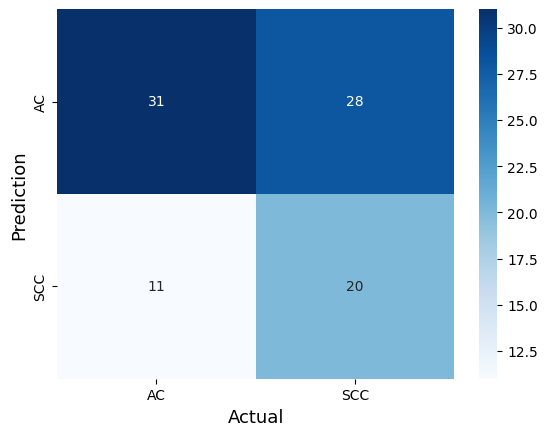

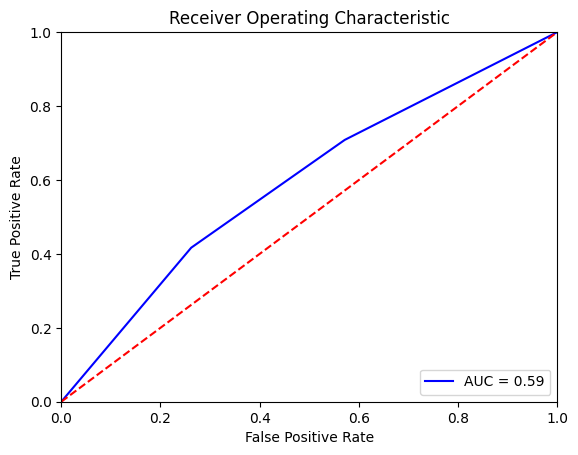

In [119]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import optuna
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

# Set the random seed
RANDOM_SEED = 1708219
np.random.seed(RANDOM_SEED)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def objective(trial):
    temp_acc = []

    n_neighbors = trial.suggest_int("n_neighbors", 1, 10)
    weights = trial.suggest_categorical("weights", ["uniform", "distance"])
    p = trial.suggest_int("p", 1, 5)

    # K-fold stratified split
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_temp, x_val_temp = x_train[train_index], x_train[test_index]
        y_train_temp, y_val_temp = y_train[train_index], y_train[test_index]

        model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)

        # Training the model
        model.fit(x_train_temp, y_train_temp.ravel())

        y_pred = model.predict(x_val_temp)

        acc = metrics.accuracy_score(y_val_temp, y_pred)
        temp_acc.append(acc)

    return np.mean(temp_acc)

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

# Best parameters
print("Best parameters:")
print(study.best_params)

# Extract the best parameters
n_neighbors = study.best_params["n_neighbors"]
weights = study.best_params["weights"]
p = study.best_params["p"]

# Train the final model with the best parameters
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
model_knn.fit(x_train, y_train)

y_pred_knn = model_knn.predict(x_test)

# Print the training and test accuracy
print("Training Accuracy is:", model_knn.score(x_train, y_train))
print("Classification Accuracy is:", model_knn.score(x_test, y_test))

# Classification report
target_names = ['Adenocarcinoma', 'Squamous']
print(classification_report(y_test, y_pred_knn, target_names=target_names))

# Confusion matrix
dat_lr = confusion_matrix(y_pred_knn, y_test)
sns.heatmap(dat_lr, annot=True, xticklabels=['AC', 'SCC'],
            yticklabels=['AC', 'SCC'], cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)

# Save the confusion matrix as an SVG file
#plt.savefig("/home/dell/NSCLC code/20_08_24/Data/97_samples/KNN_test_data_confusion_matrix.svg", format='svg')

# Save the confusion matrix as an SVG file
plt.savefig("KNN1_test_data_confusion_matrix.svg", format='svg')
plt.show()

# ROC Curve
probs_knn_test = model_knn.predict_proba(x_test)
preds_knn_test = probs_knn_test[:, 1]

fpr_knn_test, tpr_knn_test, threshold_knn_test = metrics.roc_curve(y_test, preds_knn_test)
roc_auc_knn_test = metrics.auc(fpr_knn_test, tpr_knn_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_knn_test, tpr_knn_test, 'b', label='AUC = %0.2f' % roc_auc_knn_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


#### 8.1.2.10 Sk-learn Neural Network Optimisation

##### 8.1.2.10.1 Degree = 1

[I 2024-12-07 00:46:42,496] A new study created in memory with name: no-name-4bf1c5f1-29aa-4ef8-ad5c-18c4b726bfd5
[I 2024-12-07 00:46:43,200] Trial 0 finished with value: 0.6223723723723724 and parameters: {'n_layers': 4, 'Num Hidden_0': 416, 'Num Hidden_1': 86, 'Num Hidden_2': 21, 'Num Hidden_3': 264, 'alpha': 0.006025460648917695, 'learning_rate': 'invscaling', 'learning_rate_init': 0.03151799233013011, 'max_iter': 548, 'tol': 0.0003817468263300128}. Best is trial 0 with value: 0.6223723723723724.
[I 2024-12-07 00:46:43,840] Trial 1 finished with value: 0.656006006006006 and parameters: {'n_layers': 4, 'Num Hidden_0': 347, 'Num Hidden_1': 81, 'Num Hidden_2': 234, 'Num Hidden_3': 23, 'alpha': 0.005677542490371786, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004951666648588315, 'max_iter': 1437, 'tol': 0.0009916321947891845}. Best is trial 1 with value: 0.656006006006006.
[I 2024-12-07 00:46:44,486] Trial 2 finished with value: 0.6394894894894894 and parameters: {'n_layers': 3

Best parameters:
{'n_layers': 5, 'Num Hidden_0': 319, 'Num Hidden_1': 130, 'Num Hidden_2': 179, 'Num Hidden_3': 14, 'Num Hidden_4': 8, 'alpha': 0.004161831201822669, 'learning_rate': 'invscaling', 'learning_rate_init': 0.0034894610854655545, 'max_iter': 1721, 'tol': 0.0006844565403891496}
Accuracy on the training data is: 0.7377049180327869
Classification Accuracy is: 0.5555555555555556
                precision    recall  f1-score   support

Adenocarcinoma       0.52      0.81      0.63        42
      Squamous       0.67      0.33      0.44        48

      accuracy                           0.56        90
     macro avg       0.59      0.57      0.54        90
  weighted avg       0.60      0.56      0.53        90



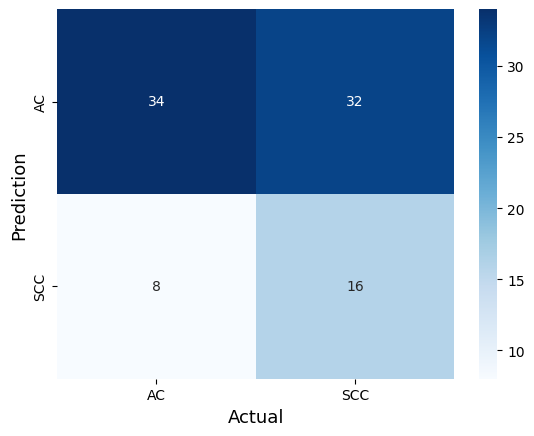

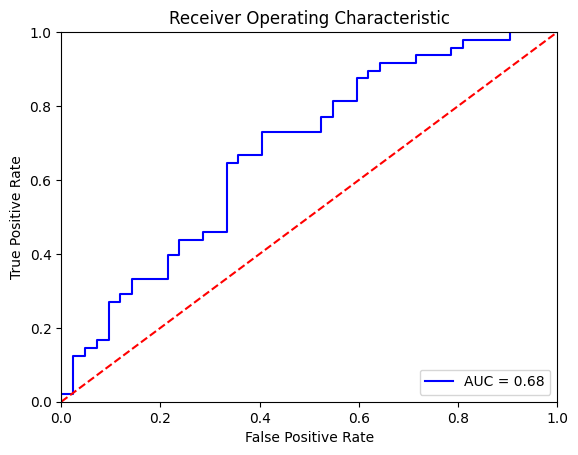

In [120]:

# Set the random seed
RANDOM_SEED = 17082122
np.random.seed(RANDOM_SEED)

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

def objective(trial):
    temp_acc = []

    n_layers = trial.suggest_int("n_layers", 1, 5)
    layers = []

    for i in range(n_layers):
        hidden_neuron = trial.suggest_int("Num Hidden_"+str(i), 1, 500)
        layers.append(hidden_neuron)

    # L2 Regularisation term
    alpha = trial.suggest_float("alpha", 1e-5, 1e-2)

    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-1)

    max_iter = trial.suggest_int("max_iter", 50, 2000)
    tol = trial.suggest_float("tol", 1e-5, 1e-3)

    # K-fold stratified Split
    for train_index, test_index in skf.split(x_train, y_train):
        x_train_temp, x_val_temp = x_train[train_index], x_train[test_index]
        y_train_temp, y_val_temp = y_train[train_index], y_train[test_index]

        model = MLPClassifier(hidden_layer_sizes=layers, alpha=alpha, learning_rate=learning_rate,
                              learning_rate_init=learning_rate_init, max_iter=max_iter, tol=tol,
                              early_stopping=True, validation_fraction=0.3, random_state=42)

        # Training the Model
        model.fit(x_train_temp, y_train_temp.ravel())

        y_pred = model.predict(x_val_temp)
        acc = metrics.accuracy_score(y_val_temp, y_pred)
        temp_acc.append(acc)

    return np.mean(temp_acc)

# Create and optimize the study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Best parameters
print("Best parameters:")
print(study.best_params)

temp_dict = study.best_params

n_layers = temp_dict["n_layers"]
layers = [temp_dict["Num Hidden_"+str(i)] for i in range(n_layers)]

alpha = temp_dict["alpha"]
learning_rate = temp_dict["learning_rate"]
learning_rate_init = temp_dict["learning_rate_init"]
max_iter = temp_dict["max_iter"]
tol = temp_dict["tol"]

# Initialize and train the final model with the best parameters
model_nn = MLPClassifier(hidden_layer_sizes=layers, alpha=alpha, learning_rate=learning_rate,
                         learning_rate_init=learning_rate_init, max_iter=max_iter, tol=tol,
                         early_stopping=True, validation_fraction=0.3, random_state=42)

model_nn.fit(x_train, y_train.ravel())

y_pred_nn = model_nn.predict(x_test)

print("Accuracy on the training data is:", model_nn.score(x_train, y_train))
print("Classification Accuracy is:", model_nn.score(x_test, y_test))

target_names = ['Adenocarcinoma', 'Squamous']
print(classification_report(y_test, y_pred_nn, target_names=target_names))

# Confusion matrix
dat_lr = confusion_matrix(y_pred_nn, y_test)
sns.heatmap(dat_lr, annot=True, xticklabels=['AC', 'SCC'],
            yticklabels=['AC', 'SCC'], cmap='Blues')
plt.ylabel('Prediction', fontsize=13)
plt.xlabel('Actual', fontsize=13)

# Save the confusion matrix as an SVG file
#plt.savefig("/home/dell/NSCLC code/20_08_24/Data/97_samples/DNN1_test_data_confusion_matrix.svg", format='svg')
# Save the confusion matrix as an SVG file
plt.savefig("DNN1_test_data_confusion_matrix.svg", format='svg')
plt.show()

# ROC Curve
probs_dnn_test = model_nn.predict_proba(x_test)
preds_dnn_test = probs_dnn_test[:, 1]

fpr_dnn_test, tpr_dnn_test, threshold_dnn_test = metrics.roc_curve(y_test, preds_dnn_test)
roc_auc_dnn_test = metrics.auc(fpr_dnn_test, tpr_dnn_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dnn_test, tpr_dnn_test, 'b', label='AUC = %0.2f' % roc_auc_dnn_test)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


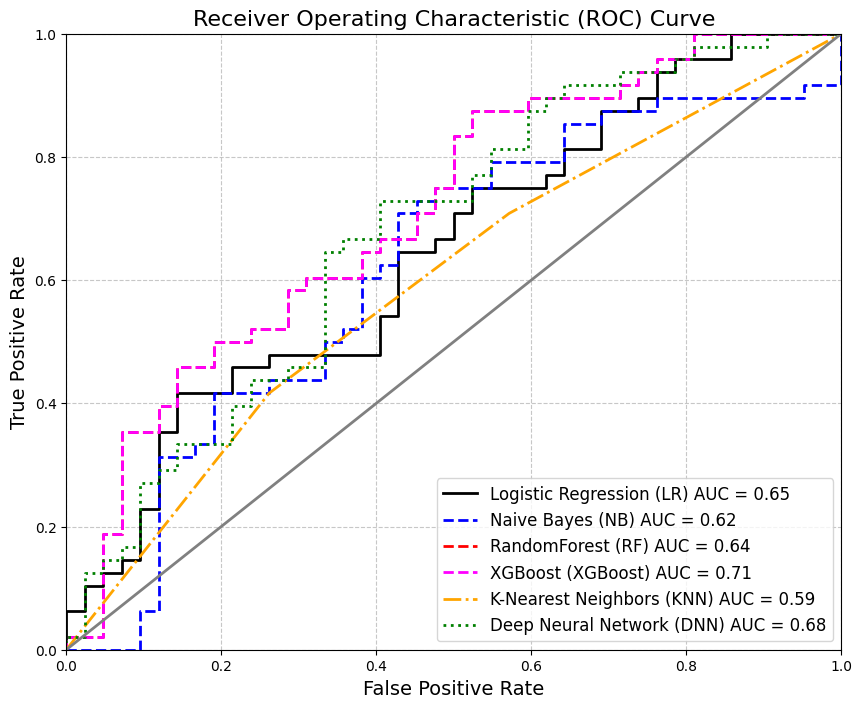

In [121]:
# LR
#ROC Curve
probs_lr_test = model_lr.predict_proba(x_test)
preds_lr_test = probs_lr_test[:,1]

fpr_lr_test, tpr_lr_test, threshold_lr_test = metrics.roc_curve(y_test, preds_lr_test)
roc_auc_lr_test = metrics.auc(fpr_lr_test, tpr_lr_test)


# NB
probs_nb_test = model_nb.predict_proba(x_test)
preds_nb_test = probs_nb_test[:,1]

fpr_nb_test, tpr_nb_test, threshold_nb_test = metrics.roc_curve(y_test, preds_nb_test)
roc_auc_nb_test = metrics.auc(fpr_nb_test, tpr_nb_test)


# RF
probs_rfc_test = model_rfc.predict_proba(x_test)
preds_rfc_test = probs_rfc_test[:,1]

fpr_rfc_test, tpr_rfc_test, threshold_rfc_test = metrics.roc_curve(y_test, preds_rfc_test)
roc_auc_rfc_test = metrics.auc(fpr_rfc_test, tpr_rfc_test)



# XGBoost
probs_xgb_test = model_xgb.predict_proba(x_test)
preds_xgb_test = probs_xgb_test[:,1]

fpr_xgb_test, tpr_xgb_test, threshold_xgb_test = metrics.roc_curve(y_test, preds_xgb_test)
roc_auc_xgb_test = metrics.auc(fpr_xgb_test, tpr_xgb_test)

# KNN
probs_knn_test = model_knn.predict_proba(x_test)
preds_knn_test = probs_knn_test[:,1]

fpr_knn_test, tpr_knn_test, threshold_knn = metrics.roc_curve(y_test, preds_knn_test)
roc_auc_knn_test = metrics.auc(fpr_knn_test, tpr_knn_test)

# DNN
probs_dnn_test = model_nn.predict_proba(x_test)
preds_dnn_test = probs_dnn_test[:,1]


fpr_dnn_test, tpr_dnn_test, threshold_dnn_test = metrics.roc_curve(y_test, preds_dnn_test)
roc_auc_dnn_test = metrics.auc(fpr_dnn_test, tpr_dnn_test)

# Plotting the AU-ROC curves
plt.figure(figsize=(10, 8))
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)

# Plot ROC curves for each model
plt.plot(fpr_lr_test, tpr_lr_test, color='black', linestyle='-', linewidth=2, label=f'Logistic Regression (LR) AUC = {roc_auc_lr_test:.2f}')
plt.plot(fpr_nb_test, tpr_nb_test, color='blue', linestyle='--', linewidth=2, label=f'Naive Bayes (NB) AUC = {roc_auc_nb_test:.2f}')
plt.plot(fpr_xgb_test, tpr_xgb_test, color='red', linestyle='--', linewidth=2, label=f'RandomForest (RF) AUC = {roc_auc_rfc_test:.2f}')
plt.plot(fpr_xgb_test, tpr_xgb_test, color='magenta', linestyle='--', linewidth=2, label=f'XGBoost (XGBoost) AUC = {roc_auc_xgb_test:.2f}')
plt.plot(fpr_knn_test, tpr_knn_test, color='orange', linestyle='-.', linewidth=2, label=f'K-Nearest Neighbors (KNN) AUC = {roc_auc_knn_test:.2f}')
plt.plot(fpr_dnn_test, tpr_dnn_test, color='green', linestyle=':', linewidth=2, label=f'Deep Neural Network (DNN) AUC = {roc_auc_dnn_test:.2f}')


# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], linewidth=2, color='gray')

# Add labels and legend
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Add grid
plt.grid(True, linestyle='--', alpha=0.7)

# Save the figure in different formats
plt.savefig('AUROC_TEST_DATA.svg')
plt.savefig('AUROC_TEST_DATA.png', format='png', dpi=1300)


# Show the plot
plt.show()


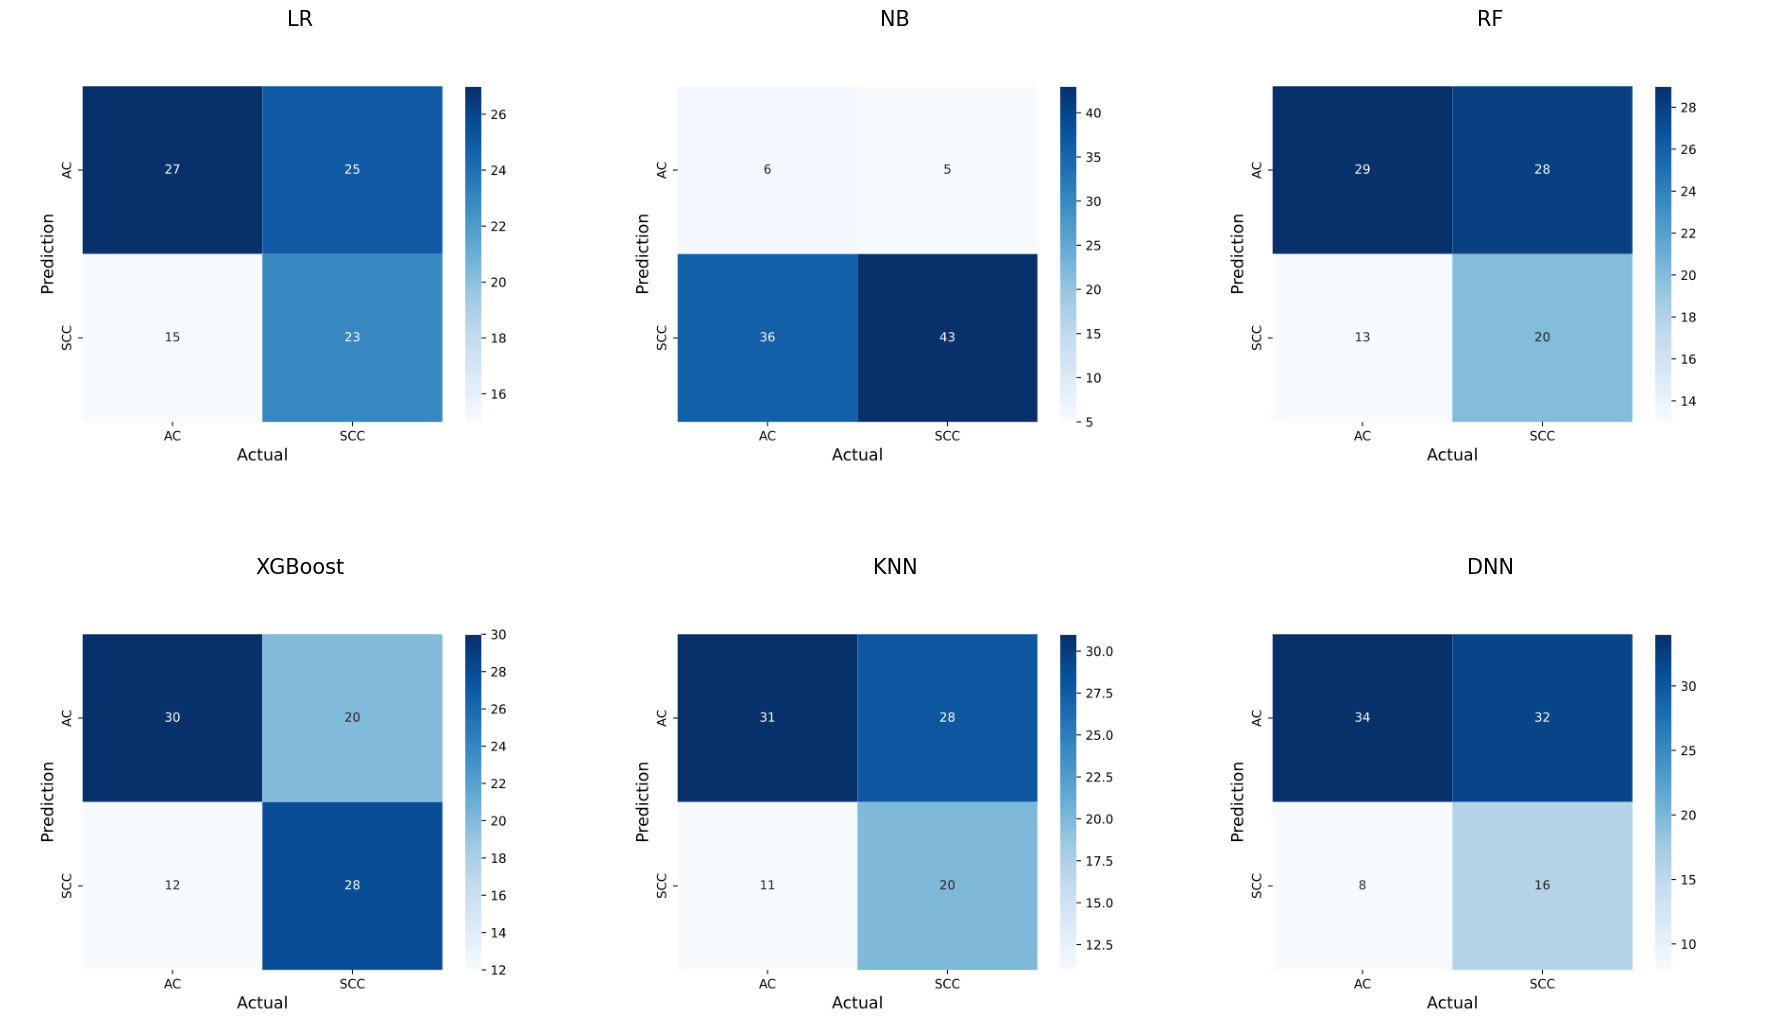

In [122]:
import matplotlib.pyplot as plt
from PIL import Image
import cairosvg
import io

# Function to convert SVG to PNG and return as an Image object
def svg_to_image(filename):
    png_data = cairosvg.svg2png(url=filename)
    img = Image.open(io.BytesIO(png_data))
    return img

# Load the SVG images and convert them to PNG
lr_img = svg_to_image('LR1_test_data_confusion_matrix.svg')
nb_img = svg_to_image('NB1_test_data_confusion_matrix.svg')
rf_img = svg_to_image('RF1_test_data_confusion_matrix.svg')
xgb_img = svg_to_image('XGB1_test_data_confusion_matrix.svg')
knn_img = svg_to_image('KNN1_test_data_confusion_matrix.svg')
dnn_img = svg_to_image('DNN1_test_data_confusion_matrix.svg')

# Create a figure with a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Function to add an image to an axis
def add_image(ax, img, title):
    ax.imshow(img)
    ax.axis('off')  # Hide the axis
    ax.set_title(title, fontsize=15)

# Add the images to the subplots
add_image(axes[0, 0], lr_img, 'LR')
add_image(axes[0, 1], nb_img, 'NB')
add_image(axes[0, 2], rf_img, 'RF')
add_image(axes[1, 0], xgb_img, 'XGBoost')
add_image(axes[1, 1], knn_img, 'KNN')
add_image(axes[1, 2], dnn_img, 'DNN')

# Adjust layout
plt.tight_layout()

# Save the figure in different formats
plt.savefig('merged_TEST_DATA_confusion_matrices.svg')
plt.savefig('merged_TEST_DATA_confusion_matrices.png', format='png', dpi=1300)
#plt.savefig('merged_confusion_matrices.png')

#plt.savefig('merged_confusion_matrices.pdf')

# Show the figure
plt.show()
